<span style="font-size: 30px">Part 1: Modeling & Forecasting Natural Gas Contract Price</span>

<span style="font-size: 20px">JPMorgan Quant Research Project via Forage</span>

Here is the background information on your task
You are a quantitative researcher working with a commodity trading desk. Alex, a VP on the desk, wants to start trading natural gas storage contracts. However, the available market data must be of higher quality to enable the instrument to be priced accurately. They have sent you an email asking you to help extrapolate the data available from external feeds to provide more granularity, considering seasonal trends in the price as it relates to months in the year. To price the contract, we will need historical data and an estimate of the future gas price at any date.

Commodity storage contracts represent deals between warehouse (storage) owners and participants in the supply chain (refineries, transporters, distributors, etc.). The deal is typically an agreement to store an agreed quantity of any physical commodity (oil, natural gas, agriculture) in a warehouse for a specified amount of time. The key terms of such contracts (e.g., periodic fees for storage, limits on withdrawals/injections of a commodity) are agreed upon inception of the contract between the warehouse owner and the client. The injection date is when the commodity is purchased and stored, and the withdrawal date is when the commodity is withdrawn from storage and sold. 

A client could be anyone who would fall within the commodities supply chain, such as producers, refiners, transporters, and distributors. This group would also include firms (commodities trading, hedge funds, etc.) whose primary aim is to take advantage of seasonal or intra-day price differentials in physical commodities. For example, if a firm is looking to buy physical natural gas during summer and sell it in winter, it would take advantage of the seasonal price differential mentioned above. The firm would need to leverage the services of an underground storage facility to store the purchased inventory to realize any profits from this strategy.

<span style="font=size: 20px">Here is your task</span>
After asking around for the source of the existing data, you learn that the current process is to take 
a monthly snapshot of prices from a market data provider, which represents the market price of natural gas 
delivered at the end of each calendar month. This data is available for roughly the next 18 months and 
is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file.

You should use this monthly snapshot to produce a varying picture of the existing price data, 
as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

Download the monthly natural gas price data.
Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 
Your code should take a date as input and return a price estimate.
Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. 
This can include looking at months of the year for seasonal trends that affect the prices, 
but market holidays, weekends, and bank holidays need not be accounted for. 

In [322]:
# TASKS:
# visualize the data - consider what factors might cause the price of NG to vary?
# estimate the purchase price of gas at any date in the past
# extrapolate price for one year into the future
# INPUT: date, OUTPUT: estimated price

In [149]:
# import libraries to be utilized
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import date 

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


# statistical tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

# models
from sklearn.linear_model import LinearRegression

from pmdarima import ARIMA
from pmdarima import AutoARIMA
from pmdarima import model_selection

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsforecast.models import AutoARIMA

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.common import space
from autogluon.timeseries.splitter import ExpandingWindowSplitter

# misc
from itertools import product
from IPython.display import display


Pre-processing

In [2]:
# import the csv and see basic info
df = pd.read_csv(r'C:\Users\jpkdu\Documents\GitHub\FinancialEngineering\JPMorgan - Quant Research\Task 1\Nat_Gas.csv')

# format dates to datetime
df['Dates'] = pd.to_datetime(df['Dates'])

df = df.set_index('Dates')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-10-31 to 2024-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prices  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


C:\Users\jpkdu\AppData\Local\Temp\ipykernel_14800\1852425357.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


In [4]:
df.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


In [5]:
df.tail()

,Prices
Dates,
2024-05-31,11.4
2024-06-30,11.5
2024-07-31,11.6
2024-08-31,11.5
2024-09-30,11.8


In [6]:
# check for missing data in the dataset
df.isnull().sum()

Prices    0
dtype: int64

In [7]:
# checks for inconsistent data types for each column
df.applymap(type).nunique()

C:\Users\jpkdu\AppData\Local\Temp\ipykernel_14800\355998948.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(type).nunique()


Prices    1
dtype: int64

Time-series Visualizations

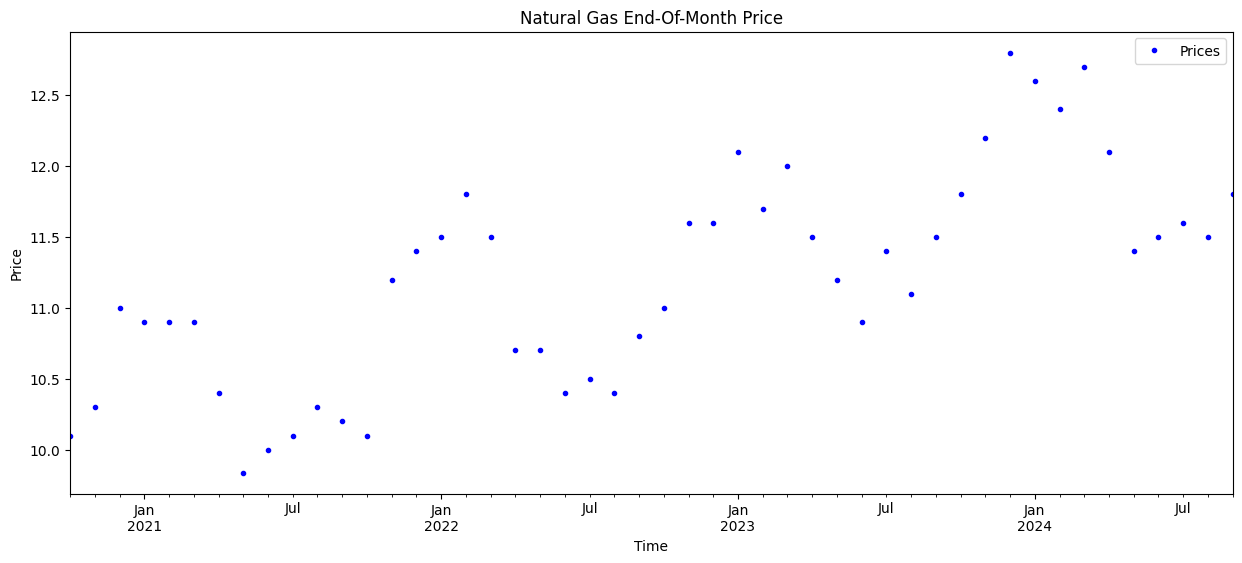

In [10]:
# time vs price plot
plt.figure(figsize=(15,6))
df['Prices'].plot(style='.', color='blue')

plt.title('Natural Gas End-Of-Month Price')
plt.xlabel('Time')
plt.ylabel('Price')

plt.legend()

plt.show()

<Axes: xlabel='year', ylabel='Prices'>

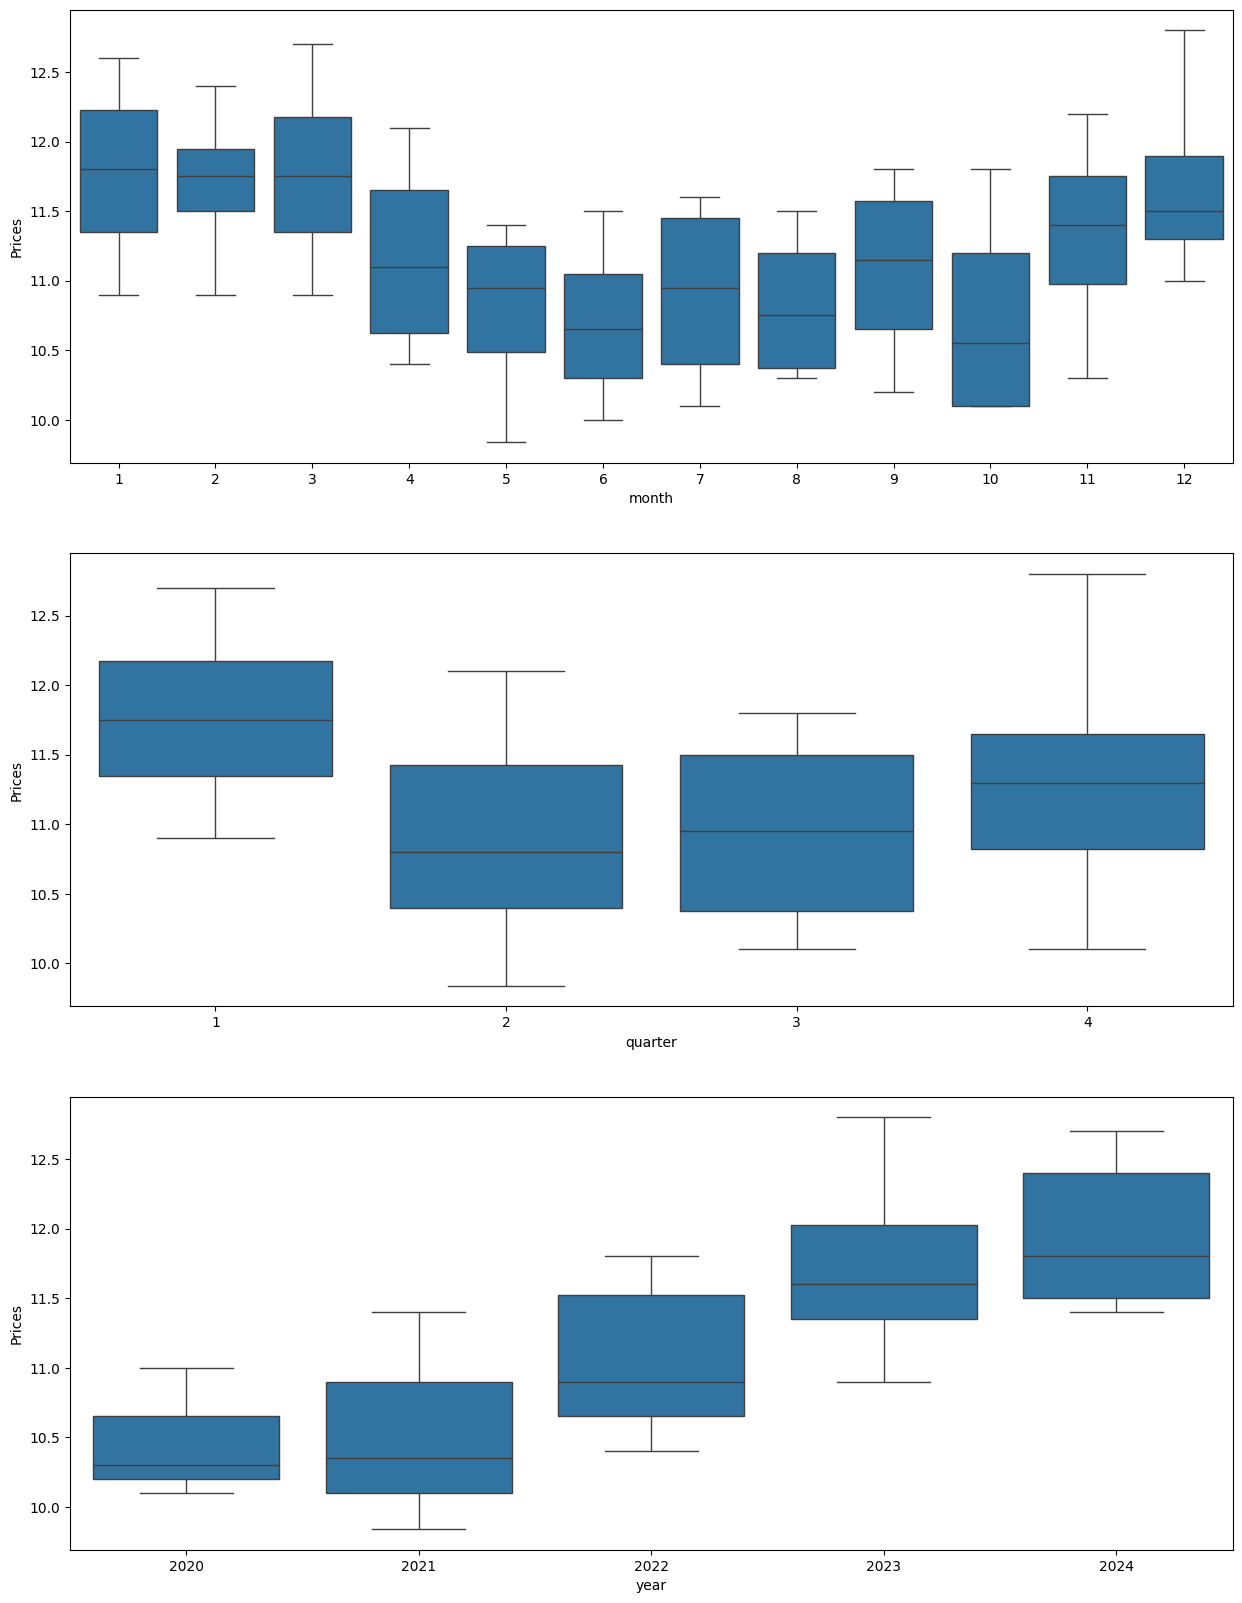

In [12]:
# Box-plot visualizations of monthly datapoints to consolidated time periods

feat_viz_df = df.copy(deep=True) # copy the original

# create monthly, quarterly, yearly features for visualization
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = pd.to_datetime(df.index).quarter
    df['month'] = pd.to_datetime(df.index).month
    df['year'] = pd.to_datetime(df.index).year

    return df

feat_viz_df = create_features(feat_viz_df)

# visualize monthly boxplots
import seaborn as sns

fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(15,20))
sns.boxplot(data=feat_viz_df, x='month', y='Prices', ax=ax1)
sns.boxplot(data=feat_viz_df, x='quarter', y='Prices', ax=ax2)
sns.boxplot(data=feat_viz_df, x='year', y='Prices', ax=ax3)


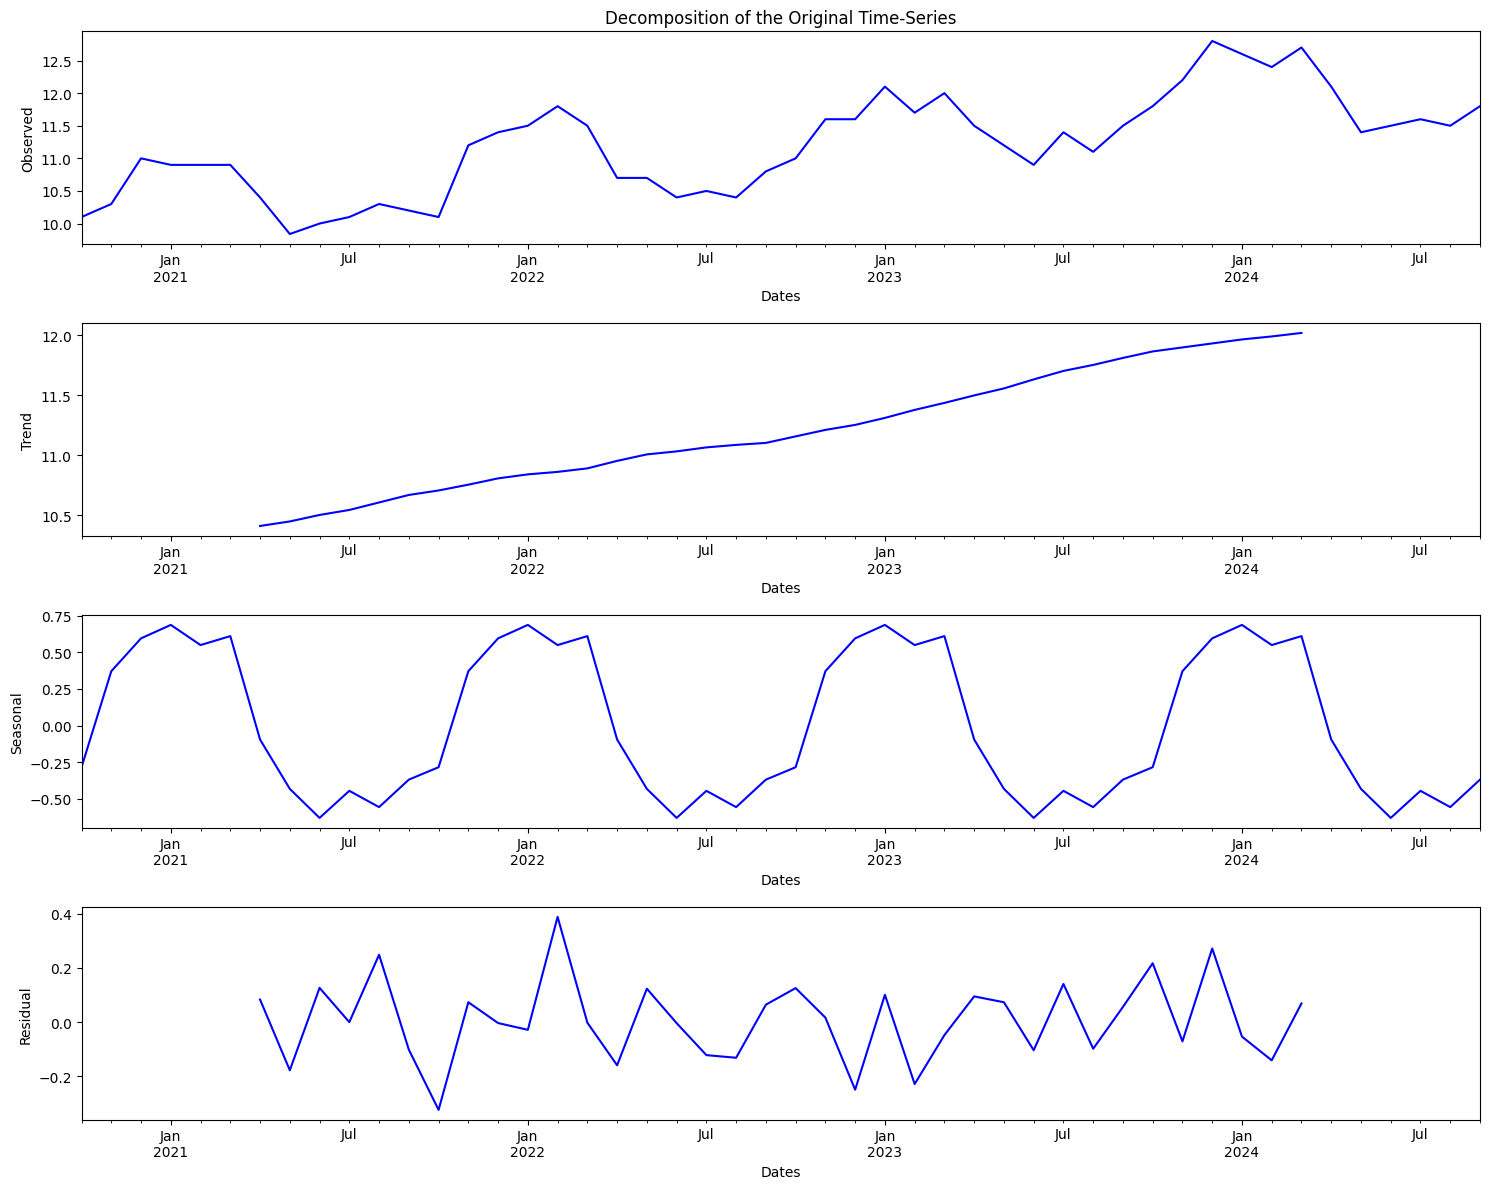

In [21]:
# visualize the seasonal & trend components of the original time-series
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Prices'], model='additive', period=12)

# plotting decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15,12))

result.observed.plot(ax=ax1, color='blue', title='Decomposition of the Original Time-Series')
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2, color='blue')
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3, color='blue')
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4, color='blue')
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

 

Deploy Box-Jenkins approach

Transformations: De-trending and differencing

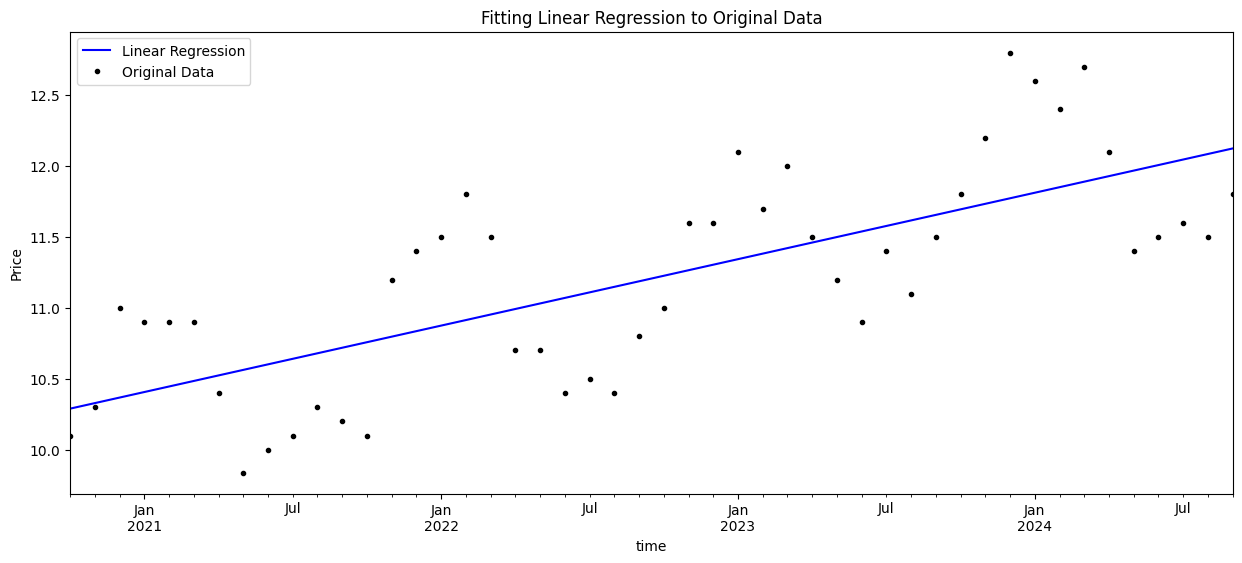

In [25]:
# From the original time-series, get rid of the trend by deploying linear regeression
from sklearn.linear_model import LinearRegression

# create linear regression model
linear_reg_model = LinearRegression()

# create a discrete-time index feature 
df['time index'] = range(0, len(df.index))

# train the model based on the original data
X_train = df[['time index']] # indepndent variable requires df object
y_train = df['Prices']
linear_reg_model.fit(X_train, y_train)

# extract the dependent variables i.e. "make predictions"
y_pred = linear_reg_model.predict(X_train)
linear_reg_df = pd.DataFrame(data=y_pred, index=df.index, columns=['y_pred']) # turn into df
linear_reg_df

# plot 
plt.figure(figsize=(15,6))

linear_reg_df['y_pred'].plot(kind='line', color='blue', label='Linear Regression')
df['Prices'].plot(style='.', color='black', label='Original Data')

plt.xlabel('time')
plt.ylabel('Price')
plt.title('Fitting Linear Regression to Original Data')

plt.legend()
plt.show()



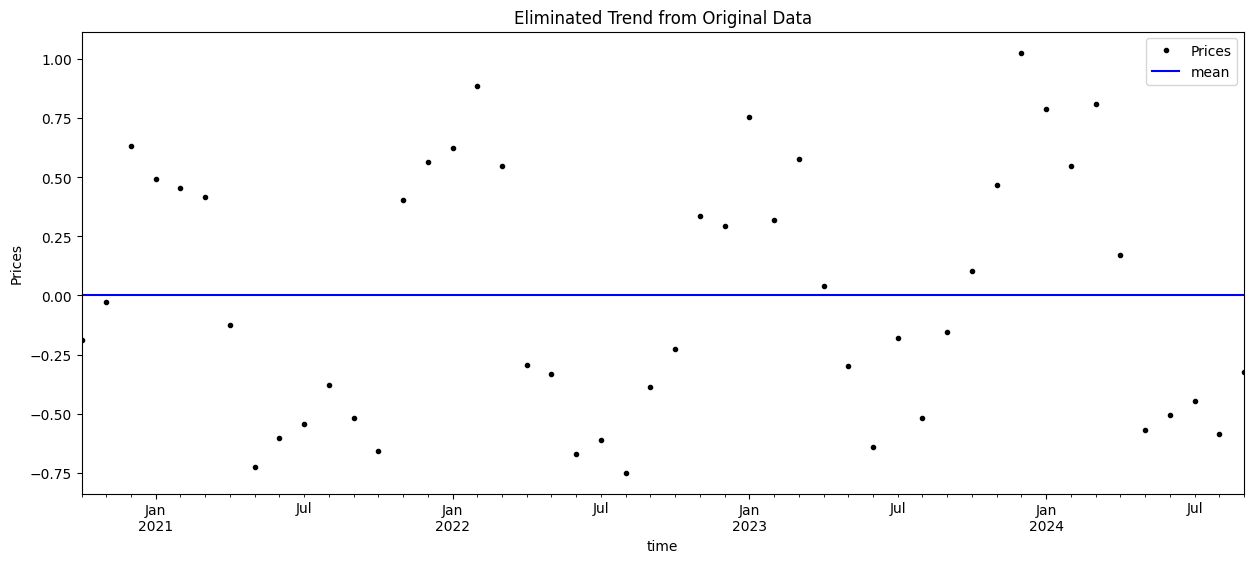

In [26]:
# detrend original data by subtracting the linear regression line
no_trend_ser = df['Prices'].subtract(linear_reg_df['y_pred']) # REMARK: dividing it yields the same shape of the plot
no_trend_df = pd.DataFrame(data=no_trend_ser, index=df.index, columns=['Prices'])

# estimate mean
no_trend_df_mean = no_trend_df['Prices'].mean()
no_trend_df['mean'] = [no_trend_df_mean for x in no_trend_df.index]


# plot
plt.figure(figsize=(15,6))
no_trend_df['Prices'].plot(style='.', color='black')
no_trend_df['mean'].plot(kind='line', color='blue')

plt.legend()
plt.xlabel('time')
plt.ylabel('Prices')
plt.title('Eliminated Trend from Original Data')

plt.show()

# uncomment if no differencing is deployed
#diff_no_trend_df = no_trend_df

# NEXT STEPS: IMPLEMENT ADFULLER and KPSS TEST FOR STATIONARITY
# https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/#google_vignette
# https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

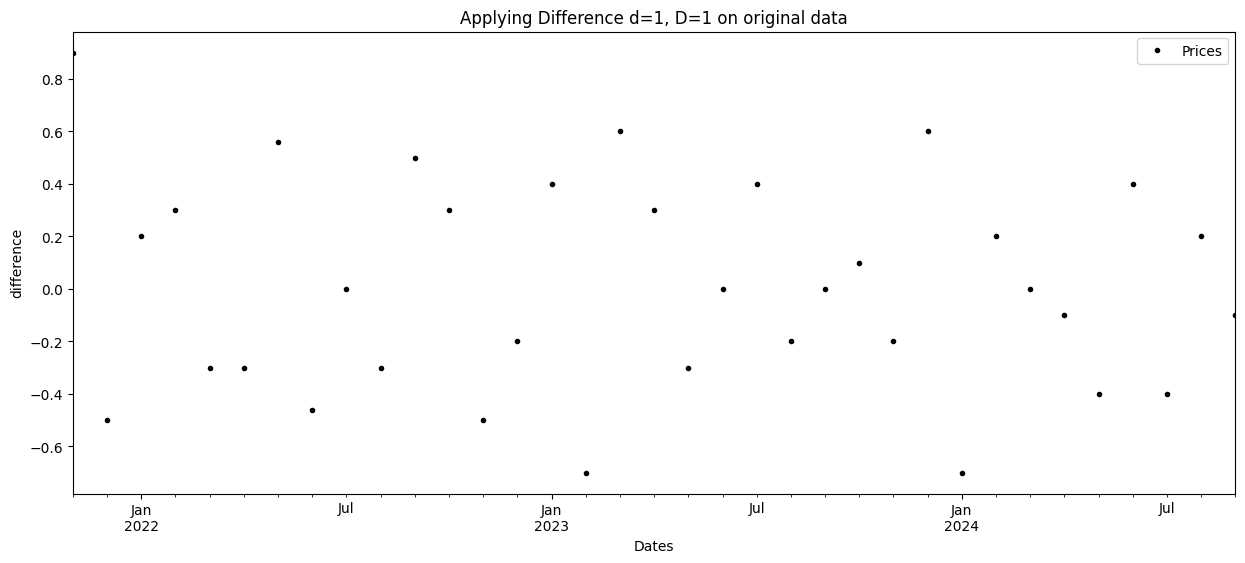

In [28]:
# apply differencing on original time-series
m = 12 # seasonal
d = 1
D = 1

ht = no_trend_df.copy(deep=True) # de-trended series
yt = no_trend_df.diff(m*D).copy(deep=True) # apply seasonal differencing

diff_df = yt.diff(d).copy(deep=True) # apply simple differencing
#diff_df = yt.copy(deep=True) # uncomment to NOT apply simple differencing

zt = diff_df.copy(deep=True) # simple and seasonal differenced
diff_df = diff_df.dropna()


'''
from statsmodels.tsa.statespace.tools import diff
# apply differencing
D = 1 # seasonal differencing
d = 1 # simple differencing
diff_df = diff(no_trend_df, k_diff=d, k_seasonal_diff=D, seasonal_periods=12)
'''

# plotting differenced data
fig = plt.figure(figsize=(15,6))
diff_df["Prices"].plot(style='.', color='black')

plt.title(f'Applying Difference d={d}, D={D} on original data')
plt.ylabel('difference')

plt.legend()
plt.show()



In [29]:
# conslidated the differenced series

combined_df = pd.concat([df['time index'],df['Prices'], linear_reg_df['y_pred'],ht['Prices'],yt['Prices'],zt['Prices']], axis=1)
combined_df.columns = ['time index', 'orig', 'trend','ht', 'yt', 'zt']

#combined_df # will be used later for forecasting

Apply Stationary Tests: ADF and KPSS

In [30]:
# test for stationarity
# Test 1: Augmented Dickey Fuller (ADF) test

# Null Hypothesis: The series has a unit root. (not stationary - roots of the B-operator is within the unit circle)
# Alternate Hypothesis: The series has no unit root. (stationary - roots of the B-operator is outside the unit circle)
# If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print('Results of ADF Test: ')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(
        dftest[0:4], # returns a tuple containing numerical results from the test
        # labels the numerical results from adfuller
        index = [
            'Test Statistic',
            'p-value',
            '#Lags Used',
            'Number of Observations Used'
        ]
    )
    # extracts the dictionary of resulting critical values from adfuller
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    print(dfoutput) # returns the output df

    # Reject or Do Not Reject Null Hypothesis?
    crit_values = [0.01, 0.05, 0.10]
    p_value = dftest[1]

    for alpha in crit_values:
        if p_value < alpha:
            print(f'@ Critical Value ({int(alpha*100)}%) ---> Reject Null Hypothesis = Time-series is Stationary')
        else:
            print(f'@ Critical Value ({int(alpha*100)}%) ---> Failed to Reject Null Hypothesis = Time-series is Not Stationary')

    
# REMARK: the series require to be stationary in order for the Box-Jenkins approach to work
# d=1 differencing gives the lowest p-value
#adf_test(diff_df['Prices'])
adf_test(diff_df['Prices'])

Results of ADF Test: 
Test Statistic                -8.067866e+00
p-value                        1.578393e-12
#Lags Used                     1.000000e+00
Number of Observations Used    3.300000e+01
Critical Value (1%)           -3.646135e+00
Critical Value (5%)           -2.954127e+00
Critical Value (10%)          -2.615968e+00
dtype: float64
@ Critical Value (1%) ---> Reject Null Hypothesis = Time-series is Stationary
@ Critical Value (5%) ---> Reject Null Hypothesis = Time-series is Stationary
@ Critical Value (10%) ---> Reject Null Hypothesis = Time-series is Stationary


In [31]:
# test for stationarity
# Test 2: Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test

# Null Hypothesis: The process is trend stationary. (i.e. trend is constant)
# Alternate Hypothesis: The series has a unit root (series is not stationary).

from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags='auto')
    kpss_output = pd.Series(
        kpsstest[0:3], 
        index=['Test Statistic',
                    'p-value',
                    'Lags Used']
    )

    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' % key] = value

    print(kpss_output)

    # Reject or Failed to Reject Null Hypothesis
    crit_values = [0.10, 0.05, 0.025, 0.01]
    p_value = kpsstest[1]
    for alpha in crit_values:
        if p_value < alpha:
            print(f'@ Critical Value ({int(alpha*100)}%) ---> Reject Null Hypothesis = Time-series is Not Stationary')
        else:
            print(f'@ Critical Value ({int(alpha*100)}%) ---> Failed to Reject Null Hypothesis = Time-series is [Trend] Stationary')


kpss_test(diff_df['Prices'])



Results of KPSS Test:
Test Statistic            0.420390
p-value                   0.068366
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
@ Critical Value (10%) ---> Reject Null Hypothesis = Time-series is Not Stationary
@ Critical Value (5%) ---> Failed to Reject Null Hypothesis = Time-series is [Trend] Stationary
@ Critical Value (2%) ---> Failed to Reject Null Hypothesis = Time-series is [Trend] Stationary
@ Critical Value (1%) ---> Failed to Reject Null Hypothesis = Time-series is [Trend] Stationary


Plot ACF and PACF for model identification

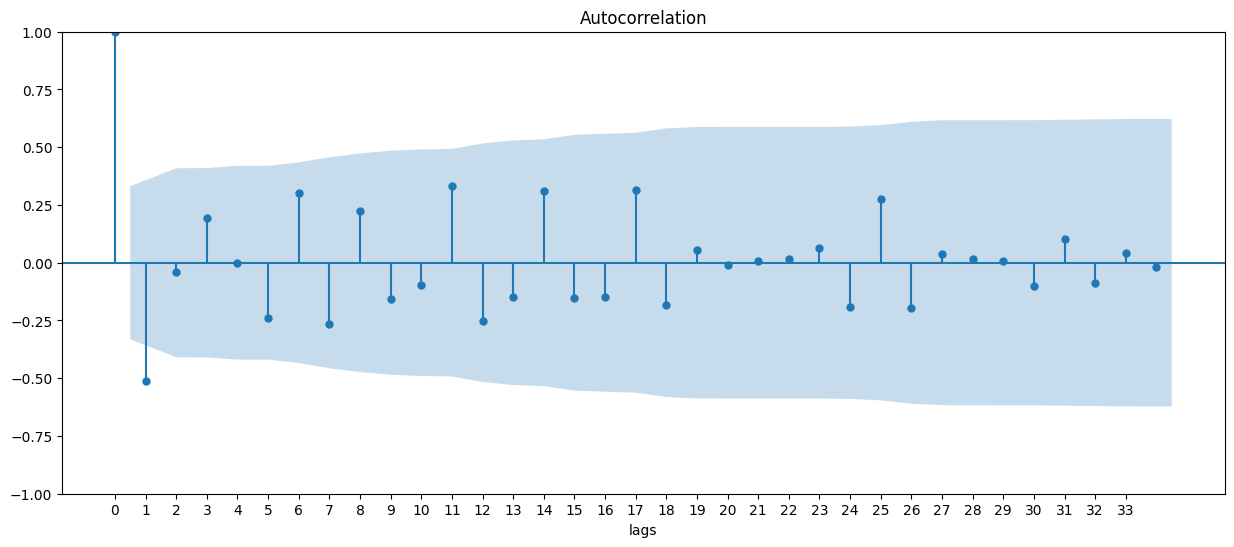

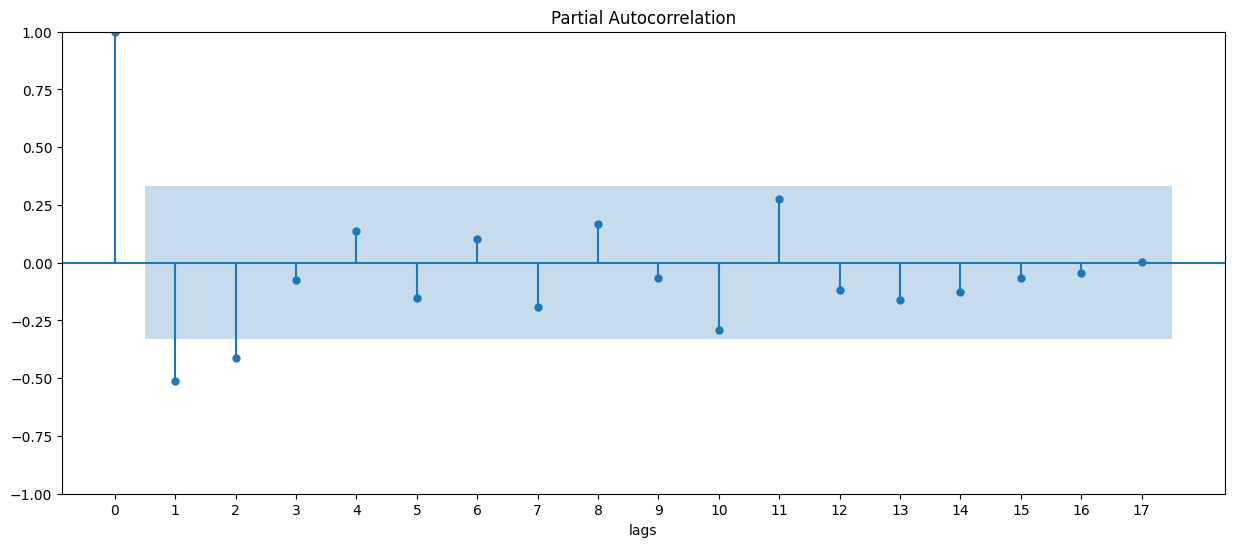

In [33]:
# plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# ACF
fig = plt.figure(figsize=(15,6))
plot_acf(diff_df['Prices'], lags=len(diff_df.index)-1, alpha=0.05, ax=plt.gca())

plt.xticks(np.arange(0,len(diff_df.index)-1, 1)) # make the lags more granular
plt.xlabel('lags')
plt.show()


# pacf
fig = plt.figure(figsize=(15,6))
plot_pacf(diff_df['Prices'], lags=len(diff_df.index)/2, alpha=0.05, ax=plt.gca())

plt.xticks(np.arange(0,len(diff_df.index)/2, 1)) # make the lags more granular
plt.xlabel('lags')
plt.show()

# REMARK: based from ACF & PACF plots below, estimated model is ARIMA(0,0,1)x(0,1,0,12) 

Estimate the best parameters for the SARIMA model by Grid Search

In [34]:
# Brute-force Grid Search to find the best parameters based on the lowest AIC

# based from the ACF and PACF plots, choose ranges of parameter values for the SARIMA model 
p = range(0,2+1)
d = range(0,2)
q = range(0,2+1)
P = range(0,2+1)
D = [1]
Q = range(0,2+1)
s = [12]


# split train and test set 
perc_train = 0.70 # percent of dataset that will be assinged as training set
X_train = diff_df.iloc[:int( len(diff_df)*perc_train )]
X_val = diff_df.iloc[int( len(diff_df)*perc_train ):]


# all possible permutations of parameter values are fed into the SARIMA model and obtain corresponding AIC value
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

aic_dict = dict() # tracks AIC values
for w in [x for x in product(p,d,q, P,D,Q,s)]:
    # extract non-seasonal and seasonal orders from the current iteration
    order = w[:3]
    seasonal_order = w[3:]
    # train SARIMA model and extract AIC
    model = SARIMAX(X_train['Prices'], order=order, seasonal_order=seasonal_order).fit()

    # checks for parameter value / standard error ratio > 2 to be significant
    sum = np.sum( np.abs(model.params / model.bse) > 2 ) # if one of the parameters satisfies > 2, should return True=1
    # only include models that satisfy the above condition
    if sum != 0:
        aic_dict[model.aic] = (order, seasonal_order) # store the aic value and corresponding order and seasonal order combination


# extract the lowest AIC values 
aic_list = [i for i in aic_dict.keys()]
aic_arr = np.array(aic_list)
aic_lowest = np.sort(aic_arr)[:15] # lowest AIC values

# outputs the five best parameters to further check:
for aic in aic_lowest:
    print(f'AIC = {aic} : {aic_dict[aic]}')

c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\s

AIC = 23.290907643826642 : ((2, 0, 1), (1, 1, 0, 12))
AIC = 24.418664985801826 : ((2, 0, 0), (0, 1, 0, 12))
AIC = 24.71889250082186 : ((2, 0, 1), (0, 1, 0, 12))
AIC = 24.996405818588673 : ((2, 0, 1), (0, 1, 1, 12))
AIC = 25.1832812286741 : ((2, 0, 0), (1, 1, 0, 12))
AIC = 25.286527505079103 : ((2, 0, 1), (1, 1, 1, 12))
AIC = 25.402853327569375 : ((2, 0, 0), (0, 1, 1, 12))
AIC = 26.30634448976825 : ((2, 0, 1), (0, 1, 2, 12))
AIC = 26.361905594945654 : ((2, 1, 0), (0, 1, 0, 12))
AIC = 26.654798145040996 : ((2, 0, 2), (0, 1, 0, 12))
AIC = 27.06045382739807 : ((0, 0, 0), (0, 1, 0, 12))
AIC = 27.131177246927795 : ((2, 0, 0), (2, 1, 0, 12))
AIC = 27.15760291862429 : ((2, 0, 0), (1, 1, 1, 12))
AIC = 27.17306507306498 : ((2, 0, 0), (0, 1, 2, 12))
AIC = 27.23832768550944 : ((2, 0, 2), (1, 1, 1, 12))


c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting & validating a seasonal ARIMA model and showing summary

c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


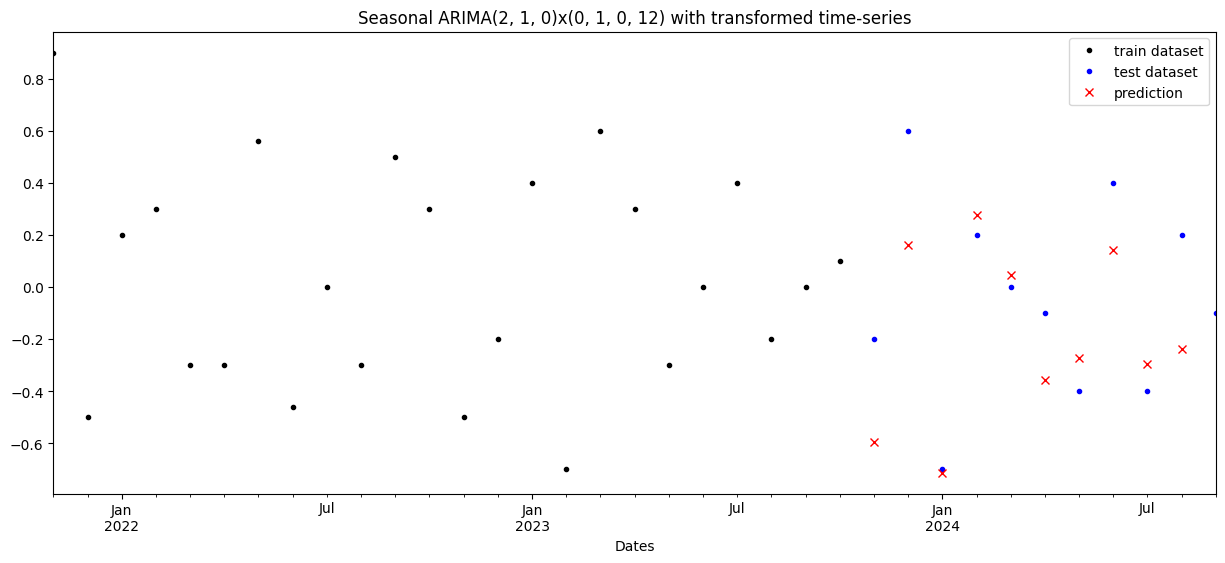

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Prices   No. Observations:                   24
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -10.181
Date:                            Wed, 05 Feb 2025   AIC                             26.362
Time:                                    20:13:19   BIC                             27.556
Sample:                                11-30-2021   HQIC                            25.609
                                     - 10-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8093      0.264     -3.068      0.002      -1.326      -0.292
ar.L2         -0.8081      0.196     -4.115      0.000      -1.193      -0.423
sigma2         0.3013      0.193      1.558      0.119      -0.078       0.680
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.85   Prob(JB):                         0.84
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Correlation Matrix of Parameters


,ar.L1,ar.L2,sigma2
ar.L1,1.000000,0.056134,0.416643
ar.L2,0.056134,1.000000,0.224673
sigma2,0.416643,0.224673,1.000000


parameter/SE ratio


ar.L1     3.067901
ar.L2     4.114719
sigma2    1.557971
dtype: float64

In [80]:
# NEXT STEPS:  build model to fit
# https://www.youtube.com/watch?v=_Tc2IDEzbDE
# https://analyzingalpha.com/interpret-arima-results

from statsmodels.tsa.statespace.sarimax import SARIMAX

# split train and test set 
perc_train = 0.70 # percent of dataset that will be assinged as training set
X_train = diff_df.iloc[:int( len(diff_df)*perc_train )]
X_val = diff_df.iloc[int( len(diff_df)*perc_train ):]
#X_train = df[['Prices']].iloc[:int( len(diff_df)*perc_train )]
#X_val = df[['Prices']].iloc[int( len(diff_df)*perc_train ):]


# fit into seasonal ARIMA model
order = (2, 1, 0) #(0,0,1)
seasonal_order =  (0,1,0,12)
model = SARIMAX(X_train['Prices'], order=order, seasonal_order=seasonal_order, simple_differencing = False).fit()
# NOTEl: shift of -1 is applied because, when shifted, it was observed that the model predictions considerably align with the validation set 
y_pred = model.forecast(len(X_val)).shift(-1) 


# plot
fig = plt.figure(figsize=(15,6))

X_train['Prices'].plot(style='.', color='black', label='train dataset')
X_val['Prices'].plot(style='.', color='blue', label='test dataset')
y_pred.plot(style='x', color='red', label='prediction')


plt.title(f'Seasonal ARIMA{order}x{seasonal_order} with transformed time-series')
plt.legend()
plt.show()


# showing summary of outputs from the model
from IPython.display import display

display(model.summary())

# print correlation matrix of parameters
cov_params_matrix = model.cov_params()
std_devs = np.sqrt( np.diag(cov_params_matrix) )
corr_params_matrix = cov_params_matrix / np.outer(std_devs, std_devs)
print('Correlation Matrix of Parameters')
display(corr_params_matrix)

# print parameters/standard error (check if > 2 to be significant)
print('parameter/SE ratio')
display( np.abs(model.params / model.bse) )


# REMARKS:
# varying the perc_train significantly affects the AIC of the model
#  
# below are the identified best models based on lowest AIC, high SE of parameters, and low correlations among parameters
# ARIMA (2, 1, 0)x(0, 1, 0, 12) - best
#       (0, 0, 1)x(0, 1, 0, 12)

Residual Analysis - Ljung-Box and Box-Pierce tests for serial correlation of errors/residuals from SARIMA model

In [81]:
# obtain Ljung-Box test statistic and p-value
ljung_box_arr = model.test_serial_correlation(method='ljungbox')

# extract statistic and p-value
ljung_box_extract = dict()
ljung_box_extract['Q-Statistic'] = ljung_box_arr.flatten()[0] # Q-statistic
ljung_box_extract['p-value'] = ljung_box_arr.flatten()[1]

# if p-value > 0.05, then fail to reject null hypothesis: errors/residuals follow white noise process (i.e. the errors are random or uncorrelated)
if ljung_box_extract['p-value'] > 0.05:
    ljung_box_extract['result'] = 'Errors are random'
else:
    ljung_box_extract['result'] = 'Errors are not random'



# obtain Box-Pierce test statistic and p-value
box_pierce_arr = model.test_serial_correlation(method='boxpierce')

# extract statistic and p-value
box_pierce_extract = dict()
box_pierce_extract['Q-Statistic'] = box_pierce_arr.flatten()[0] # Q-statistic
box_pierce_extract['p-value'] = box_pierce_arr.flatten()[1]

# if p-value > 0.05, then fail to reject null hypothesis: errors/residuals follow white noise process (i.e. errors/residuals follow white noise process (i.e. the errors are random or uncorrelated)
if box_pierce_extract['p-value'] > 0.05:
    box_pierce_extract['result'] = 'Errors are random'
else:
    box_pierce_extract['result'] = 'Errors are not random'


lj_df = pd.DataFrame(data=ljung_box_extract.values(), index=ljung_box_extract.keys(), columns=['Ljung Box'])
bp_df = pd.DataFrame(data=box_pierce_extract.values(), index=box_pierce_extract.keys(), columns=['Box Pierce'])

residual_analysis_df = pd.concat([lj_df,bp_df], axis=1)
residual_analysis_df

,Ljung Box,Box Pierce
Q-Statistic,0.034175,0.026289
p-value,0.077196,0.056072
result,Errors are random,Errors are random


Validation - plotting model predictions against validation set and showing confidence intervals

In [85]:
# obtain prediction and confidence interval from the SARIMAX model
alpha = 0.05 # significance level of CI
# NOTEl: shift of -1 is applied because, when shifted, it was observed that the model predictions considerably align with the validation set 
y_pred_df = model.get_forecast(len(X_val.index)).summary_frame(alpha=alpha).shift(-1) # extract forecasts and confidence interval
y_pred_df = y_pred_df.reset_index() # reset the index to be relabeled
y_pred_df.columns = ['time', 'z_n+h', 'z_n+h_se', 'z_n+h_ci_lower', 'z_n+h_ci_upper'] # relabel the columns
y_pred_df = y_pred_df.set_index('time')


# update the combined_df with SARIMAX forecast
updated_combined_df = pd.concat([combined_df,y_pred_df],axis=1)

#updated_combined_df.plot(y=['z_n+h', 'z_n+h_ci_lower', 'z_n+h_ci_upper'])

Manually derived the theoretical time-series expression of the original dataset

In [86]:
# use the updated_combined_df to derive the forecasts and its confidence interval in the original dataset's domain i.e. X_n+h
# specifically for (2, 1, 0), (0, 1, 0, 12):
# X_n(h) = z_n(h) + y_n(h-1) + h_n(h-12) + mu_n(h) 

# forecast X
updated_combined_df['X_n+h'] = updated_combined_df['z_n+h'].shift(0) + updated_combined_df['yt'].shift(1) + updated_combined_df['ht'].shift(12) + updated_combined_df['trend'].shift(0)
# lower CI
updated_combined_df['X_n+h_low'] = updated_combined_df['z_n+h_ci_lower'].shift(0) + updated_combined_df['yt'].shift(1) + updated_combined_df['ht'].shift(12) + updated_combined_df['trend'].shift(0)
# upper CI 
updated_combined_df['X_n+h_up'] = updated_combined_df['z_n+h_ci_upper'].shift(0) + updated_combined_df['yt'].shift(1) + updated_combined_df['ht'].shift(12) + updated_combined_df['trend'].shift(0)


# REMARK: formula will change depending on the (p,d,q)x(P,D,Q,s) chosen

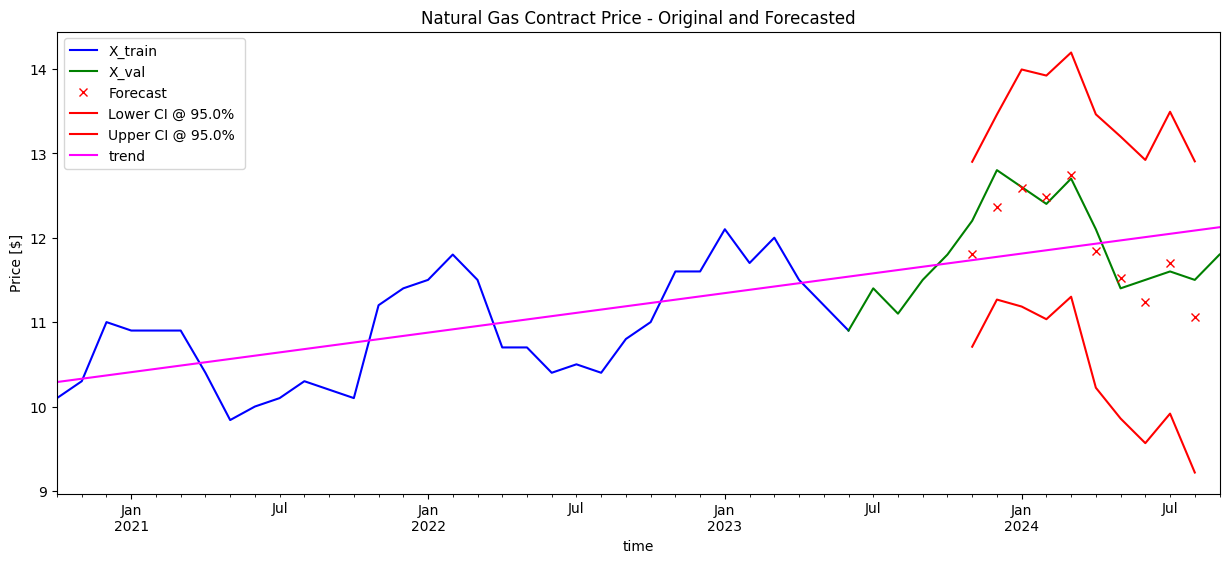

In [87]:
# plot original and forecasted values to be validated

plt.figure(figsize=(15,6))
updated_combined_df['orig'].iloc[  : int( len(updated_combined_df['orig'])*perc_train ) ].plot(kind='line',color='blue', label='X_train') # plot original series
updated_combined_df['orig'].iloc[  int( len(updated_combined_df['orig'])*perc_train ) -1: ].plot(kind='line',color='green', label='X_val')
updated_combined_df['X_n+h'].plot(style='x', color='red',label='Forecast') # plot forecasts
updated_combined_df['X_n+h_low'].plot(kind='line', color='red',label=f'Lower CI @ {100*(1-alpha)}% ') # plot lower CI
updated_combined_df['X_n+h_up'].plot(kind='line', color='red',label=f'Upper CI @ {100*(1-alpha)}%') # plot upper CI 
updated_combined_df['trend'].plot(kind='line', color='fuchsia',label='trend')

plt.ylabel('Price [$]')
plt.xlabel('time')
plt.title('Natural Gas Contract Price - Original and Forecasted')
plt.legend()

plt.show()


# REMARKS:
# by visual, model does not accurately forecast validaton data
# inaccuracies may root from transforming back the model forecasts to the original series' domain

Accuracy Metrics

In [88]:
# define a function that computes accuracy metrics
forecasted_values = updated_combined_df['X_n+h']
actual_values = updated_combined_df['orig']

##############
def accuracy_metrics(actual_values, forecasted_values):
    # pre-process input df: only grab the rows in actual values that are aligned with the indices of the forecasted values
    forecasted_values = forecasted_values.dropna().copy(deep=True)
    actual_values = actual_values.iloc[-len(forecasted_values):].copy(deep=True) 
    # convert to arrays
    forecasted_values_arr = np.array(forecasted_values)
    actual_values_arr = np.array(actual_values)



    # compute the metrics and store in dict
    metrics_dict = {
        'MAE' : np.mean(np.abs(actual_values_arr - forecasted_values_arr)),
        'RMSE': np.sqrt( np.mean( (actual_values_arr - forecasted_values_arr)**2 ) ),
        'MAPE': np.mean( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'SMAPE': 100 * np.mean(2 * np.abs(actual_values_arr - forecasted_values_arr) / ( np.abs(actual_values_arr) + np.abs(forecasted_values_arr) )  ),
        'MdAPE': np.median( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'GMRAE': np.exp( np.mean( np.log( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) ) ) ) 

    }

    # returns a df
    return pd.DataFrame(index=metrics_dict.keys(), data=metrics_dict.values(), columns=['accuracy metrics'])



SARIMA_AM = accuracy_metrics(actual_values, forecasted_values)
SARIMA_AM

,accuracy metrics
MAE,0.405983
RMSE,0.496234
MAPE,3.350591
SMAPE,3.386457
MdAPE,2.477832
GMRAE,0.024117


Alternative Model: pmdarima ARIMA model


Go through the same steps in the previous analysis and modeling above

Fitting & Validating pmdarima AutoARIMA and showing summary

**Change paramaeters to (0,0,1)x(0,1,0,12) because it was found via auto_arima and it seems to be a better fit visually

c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\jpkdu\AppData\Local\Temp\ipykernel_14800\1111156978.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['trend'] = linear_reg_model.predict(X_train[['time index']])


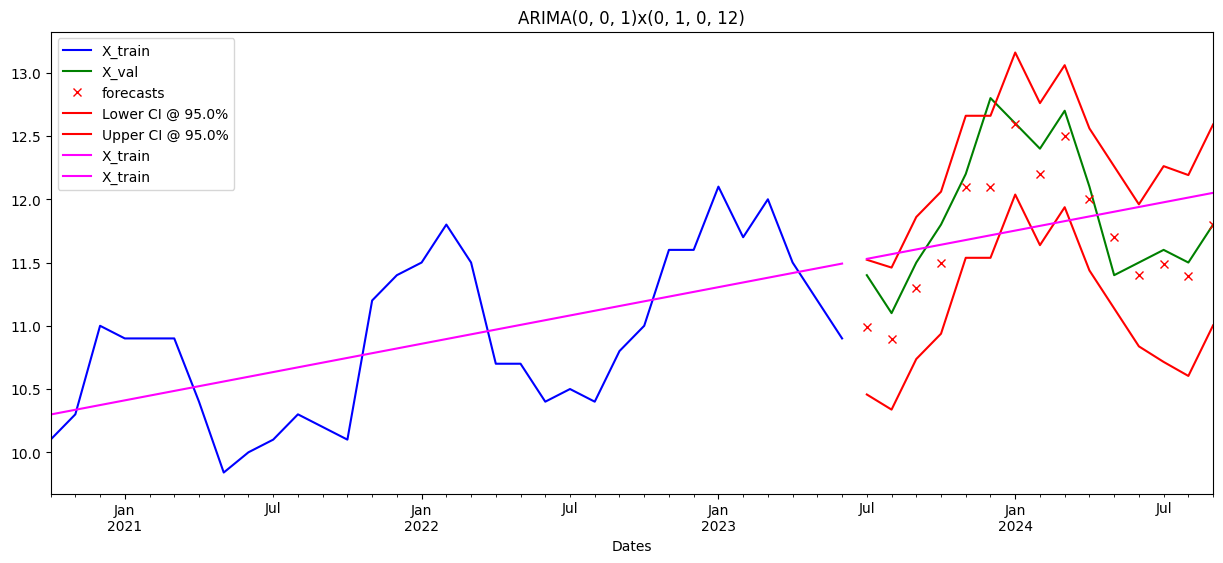

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   33
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                  -2.493
Date:                             Wed, 05 Feb 2025   AIC                             10.986
Time:                                     20:19:38   BIC                             14.120
Sample:                                 10-31-2020   HQIC                            11.666
                                      - 06-30-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4987      0.045     11.066      0.000       0.410       0.587
ma.L1         -0.3337      0.301     -1.110      0.267      -0.923       0.256
sigma2         0.0738      0.027      2.728      0.006       0.021       0.127
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.76   Prob(JB):                         0.66
Heteroskedasticity (H):               0.97   Skew:                            -0.44
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Correlation Matrix of Parameters


,intercept,ma.L1,sigma2
intercept,1.000000,0.165025,0.348334
ma.L1,0.165025,1.000000,0.010268
sigma2,0.348334,0.010268,1.000000


parameter/SE ratio


intercept    11.065876
ma.L1         1.109732
sigma2        2.728008
dtype: float64

In [103]:
from pmdarima import ARIMA

# split original time series to training and validation data
perc_train = 0.70 # define percentage of time series to be the training set and the rest will be the validating set
X_train = df.iloc[ : int(len(df)*perc_train ) ] 
X_val = df.iloc[ int(len(df)*perc_train ) :  ]

# define the parameters of the ARIMA model as found above
order = (0,0,1) # non-seasonal
seasonal_order = (0,1,0,12) # seasonal

# instantiate and fit the ARIMA model
arima_model = ARIMA(order=order, seasonal_order=seasonal_order)

# forecasting
h = len(X_val) # forecast horizon
alpha = 0.05 # significant level for confidence intervals
# extract forecasts and confidence intervals
arima_fc_summary_df = arima_model.fit(X_train['Prices']).arima_res_.get_forecast(h).summary_frame(alpha=alpha)
arima_forecast = arima_fc_summary_df['mean'] # extract forecasts

# fit the X_train with linear regression to depict as trend of the series
from sklearn.linear_model import LinearRegression
linear_reg_model = LinearRegression() # instantiate
# note that the original df has been imposed with integer time indices before splitting the dataset
linear_reg_model.fit(X=X_train[['time index']], y=X_train['Prices'])
# add the trend component to the X_train df for plotting purposes
X_train['trend'] = linear_reg_model.predict(X_train[['time index']])

# also impose the trend component to the arima_fc_summary_df for plotting purposes:
# noting the last index of X_train
last_time_index_of_X_train = len(X_train['trend'].index)
# impose integer time indices to the pmdarima_fc_summary_df continuing the count from the last index of X_train
arima_fc_summary_df['time index'] = range(last_time_index_of_X_train, last_time_index_of_X_train + len(arima_fc_summary_df))
arima_fc_summary_df['trend'] = linear_reg_model.predict( arima_fc_summary_df[['time index']] )

# plotting
plt.figure(figsize=(15,6))
# plot training & validation data
X_train['Prices'].plot(kind='line', color='blue', label='X_train')
X_val['Prices'].plot(kind='line', color='green', label='X_val')
# plot forecasts and confidence intervals
arima_fc_summary_df['mean'].plot(style='x', color='red', label='forecasts')
arima_fc_summary_df['mean_ci_lower'].plot(kind='line', color='red', label=f'Lower CI @ {(1-alpha)*100}%')
arima_fc_summary_df['mean_ci_upper'].plot(kind='line', color='red', label=f'Upper CI @ {(1-alpha)*100}%')
# impose trend line on both training and validation data
X_train['trend'].plot(kind='line', color='fuchsia', label='X_train')
arima_fc_summary_df['trend'].plot(kind='line', color='fuchsia', label='X_train')


plt.title(f'ARIMA{order}x{seasonal_order}') 
plt.legend()
plt.show()


# showing summary of outputs from the model
from IPython.display import display

display(arima_model.summary())


# print correlation matrix of parameters
cov_params_matrix = arima_model.arima_res_.cov_params()
std_devs = np.sqrt( np.diag(cov_params_matrix) )
corr_params_matrix = cov_params_matrix / np.outer(std_devs, std_devs)
print('Correlation Matrix of Parameters')
display(corr_params_matrix)

# print parameters/standard error (check if > 2 to be significant)
print('parameter/SE ratio')
display( np.abs(arima_model.arima_res_.params / arima_model.arima_res_.bse) )

# REMARKS:
# in the previous SARIMAX modeling, if the forecasted values were correctly transformed back to the original time-series, it should resemble the plot below
# when forecasting beyond 1-year, it is observed that the forecasts would deviate above the trendline

Residual Analysis - Ljung-Box and Box-Pierce tests for serial correlation of errors/residuals from SARIMA model

In [105]:
# obtain Ljung-Box test statistic and p-value
ljung_box_arr = arima_model.arima_res_.test_serial_correlation(method='ljungbox')

# extract statistic and p-value
ljung_box_extract = dict()
ljung_box_extract['Q-Statistic'] = ljung_box_arr.flatten()[0] # Q-statistic
ljung_box_extract['p-value'] = ljung_box_arr.flatten()[1]

# if p-value > 0.05, then fail to reject null hypothesis: errors/residuals follow white noise process (i.e. the errors are random or uncorrelated)
if ljung_box_extract['p-value'] > 0.05:
    ljung_box_extract['result'] = 'Errors are random'
else:
    ljung_box_extract['result'] = 'Errors are not random'


# obtain Box-Pierce test statistic and p-value
box_pierce_arr = arima_model.arima_res_.test_serial_correlation(method='boxpierce')

# extract statistic and p-value
box_pierce_extract = dict()
box_pierce_extract['Q-Statistic'] = box_pierce_arr.flatten()[0] # Q-statistic
box_pierce_extract['p-value'] = box_pierce_arr.flatten()[1]

# if p-value > 0.05, then fail to reject null hypothesis: errors/residuals follow white noise process (i.e. errors/residuals follow white noise process (i.e. the errors are random or uncorrelated)
if box_pierce_extract['p-value'] > 0.05:
    box_pierce_extract['result'] = 'Errors are random'
else:
    box_pierce_extract['result'] = 'Errors are not random'


lj_df = pd.DataFrame(data=ljung_box_extract.values(), index=ljung_box_extract.keys(), columns=['Ljung Box'])
bp_df = pd.DataFrame(data=box_pierce_extract.values(), index=box_pierce_extract.keys(), columns=['Box Pierce'])

residual_analysis_df = pd.concat([lj_df,bp_df], axis=1)
residual_analysis_df

,Ljung Box,Box Pierce
Q-Statistic,0.093403,0.08122
p-value,0.573086,0.47748
result,Errors are random,Errors are random


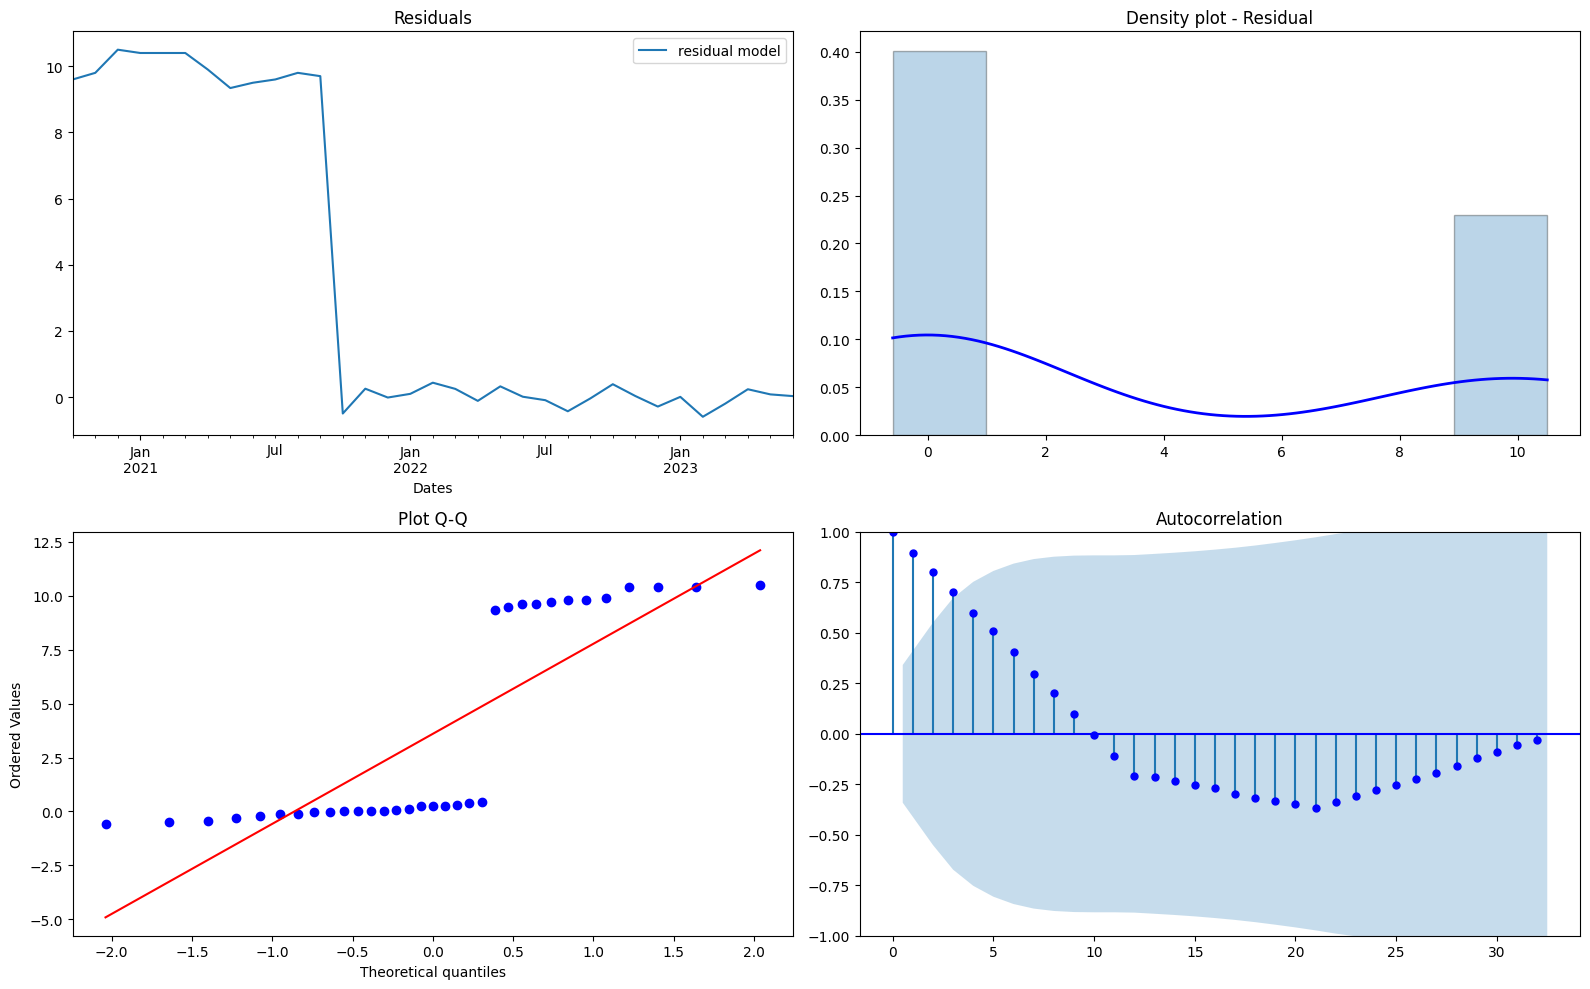

In [106]:
# visualize residuals of the model
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf

# extract residuals from the model
residual = pd.DataFrame(data=arima_model.resid(), columns=['residual model'])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

# Residual Plot
residual.plot(ax=axs[0,0])
axs[0,0].set_title('Residuals')

# Density
# plot the hist
axs[0,1].hist(residual, bins='auto', density=True, alpha=0.30, edgecolor='black')
# plot density curve
kde = stats.gaussian_kde(residual['residual model'])
x_range = np.linspace(min(residual['residual model']), max(residual['residual model']), 100)
axs[0,1].plot(x_range, kde(x_range), linewidth=2, color='blue')
axs[0,1].set_title("Density plot - Residual")

# Q-Q plot
stats.probplot(residual["residual model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# ACF plot
plot_acf(residual,  lags=len(residual)-1, ax=axs[1,1],color="blue")
axs[1,1].set_title("Autocorrelation")

plt.tight_layout()
plt.show()

# REMARK: although the Box-Ljung and Box-Pierce tests deemed the errors to be random, the visualizations below indicate otherwise 

Accuracy Metrics - comparing to the previous Manually-developed SARIMA model

In [107]:
# define a function that computes accuracy metrics
forecasted_values = arima_fc_summary_df['mean']
actual_values = X_val['Prices']

##############
def accuracy_metrics(actual_values, forecasted_values):
    # pre-process input df: only grab the rows in actual values that are aligned with the indices of the forecasted values
    forecasted_values = forecasted_values.dropna().copy(deep=True)
    actual_values = actual_values.iloc[-len(forecasted_values):].copy(deep=True) 
    # convert to arrays
    forecasted_values_arr = np.array(forecasted_values)
    actual_values_arr = np.array(actual_values)



    # compute the metrics and store in dict
    metrics_dict = {
        'MAE' : np.mean(np.abs(actual_values_arr - forecasted_values_arr)),
        'RMSE': np.sqrt( np.mean( (actual_values_arr - forecasted_values_arr)**2 ) ),
        'MAPE': np.mean( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'SMAPE': 100 * np.mean(2 * np.abs(actual_values_arr - forecasted_values_arr) / ( np.abs(actual_values_arr) + np.abs(forecasted_values_arr) )  ),
        'MdAPE': np.median( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'GMRAE': np.exp( np.mean( np.log( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) ) ) ) 

    }

    # returns a df
    return pd.DataFrame(index=metrics_dict.keys(), data=metrics_dict.values(), columns=['accuracy metrics'])



arima_AM = accuracy_metrics(actual_values, forecasted_values)

# percent difference from SARIMA model
AM_diff_df = (arima_AM - SARIMA_AM) / SARIMA_AM *100

# consolidate and compare
AM_consolidate_df = pd.concat([arima_AM,SARIMA_AM,AM_diff_df], axis=1)
AM_consolidate_df.columns = ['arima_AM','SARIMA AM', '%_diff']
display(AM_consolidate_df)

,arima_AM,SARIMA AM,%_diff
MAE,0.202615,0.405983,-50.092734
RMSE,0.265367,0.496234,-46.523812
MAPE,1.697513,3.350591,-49.336911
SMAPE,1.717316,3.386457,-49.288718
MdAPE,1.584939,2.477832,-36.035253
GMRAE,0.008713,0.024117,-63.874017


Alternative Model: pdmarima AutoARIMA

This model automatically estimates the p,d,q,P,D,Q,s parameters for us

Fitting & Validating pmdarima AutoARIMA and showing summary

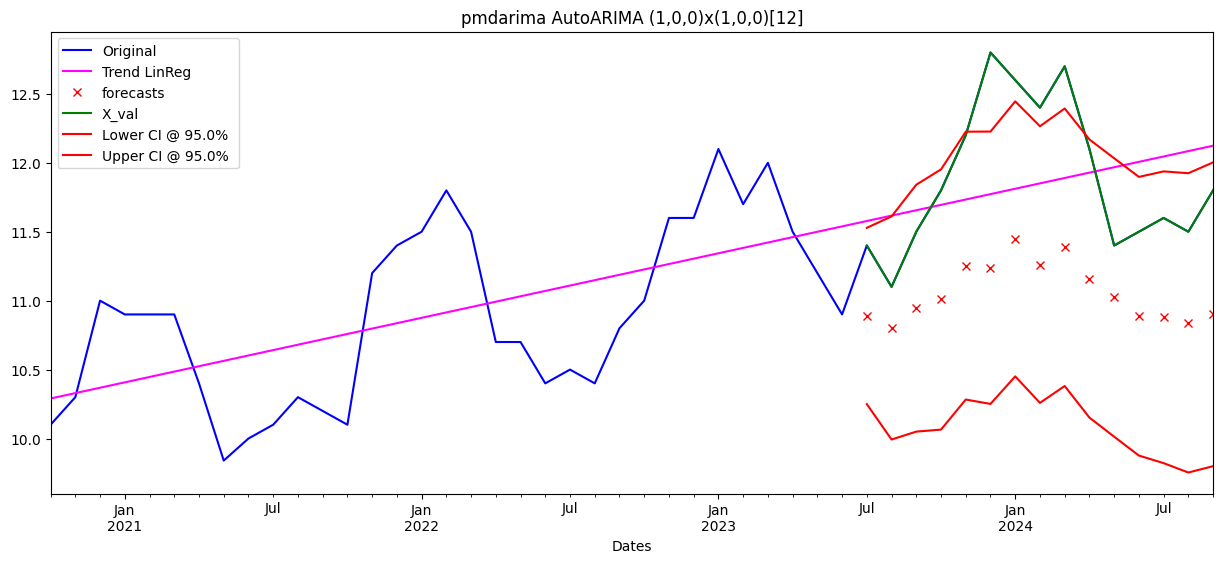

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   33
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 -11.656
Date:                            Wed, 05 Feb 2025   AIC                             31.312
Time:                                    20:26:25   BIC                             37.298
Sample:                                10-31-2020   HQIC                            33.326
                                     - 06-30-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3615      0.883      1.542      0.123      -0.369       3.092
ar.L1          0.7749      0.125      6.207      0.000       0.530       1.020
ar.S.L12       0.4429      0.246      1.799      0.072      -0.040       0.925
sigma2         0.1065      0.028      3.839      0.000       0.052       0.161
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.30
Prob(Q):                              0.68   Prob(JB):                         0.52
Heteroskedasticity (H):               1.11   Skew:                             0.48
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Correlation Matrix of Parameters


,intercept,ar.L1,ar.S.L12,sigma2
intercept,1.000000,-0.749403,-0.540274,0.079029
ar.L1,-0.749403,1.000000,-0.150427,0.210505
ar.S.L12,-0.540274,-0.150427,1.000000,-0.403509
sigma2,0.079029,0.210505,-0.403509,1.000000


parameter/SE ratio


intercept    1.541862
ar.L1        6.207038
ar.S.L12     1.799383
sigma2       3.838828
dtype: float64

In [109]:
# split dataset to training and validation
perc_train = 0.70 # define percentage of time series to be the training set and the rest will be the validating set
X_train = df.iloc[ : int(len(df)*perc_train ) ] 
X_val = df.iloc[ int(len(df)*perc_train ) : ] 

# train the ARIMA model
from pmdarima import auto_arima

pmd_auto_arima_model = auto_arima(X_train['Prices'] , seasonal=True, m=12 )

# forecasting
h = len(X_val) # forecast horizon
alpha = 0.05 # significance level for confidence intervals
pmdarima_fc_summary_df = pmd_auto_arima_model.arima_res_.get_forecast(h).summary_frame(alpha=alpha)
pmdarima_forecast = pmdarima_fc_summary_df['mean']


# plot
plt.figure(figsize=(15,6))
 
result._observed.plot(kind='line', color='blue', label='Original') # plot original
#result._trend.plot(kind='line', color='black', label='Trend Decomp') # plot trend from decomposition
updated_combined_df['trend'].plot(kind='line', color='fuchsia', label='Trend LinReg') # plot trend from linear regression
pmdarima_forecast.plot(style='x', color='red', label='forecasts') # plot forecast
X_val['Prices'].plot(kind='line', color='green', label='X_val')
# extract confidence intervals and plot
pmdarima_fc_summary_df['mean_ci_lower'].plot(kind='line', color='red',label=f'Lower CI @ {100*(1-alpha)}% ') 
pmdarima_fc_summary_df['mean_ci_upper'].plot(kind='line', color='red',label=f'Upper CI @ {100*(1-alpha)}% ')


# extract parameters
p,d,q = pmd_auto_arima_model.order
P,D,Q,s = pmd_auto_arima_model.seasonal_order

plt.title(f'pmdarima AutoARIMA ({p},{d},{q})x({P},{D},{Q})[{s}]')
plt.legend()
plt.show()


# showing summary of outputs from the model
from IPython.display import display

display(pmd_auto_arima_model.summary())


# print correlation matrix of parameters
cov_params_matrix = pmd_auto_arima_model.arima_res_.cov_params()
std_devs = np.sqrt( np.diag(cov_params_matrix) )
corr_params_matrix = cov_params_matrix / np.outer(std_devs, std_devs)
print('Correlation Matrix of Parameters')
display(corr_params_matrix)

# print parameters/standard error (check if > 2 to be significant)
print('parameter/SE ratio')
display( np.abs(pmd_auto_arima_model.arima_res_.params / pmd_auto_arima_model.arima_res_.bse) )




# REMARKS:
# visually, this model is not accurate from the get-go

Residual Analysis - Ljung-Box and Box-Pierce tests for serial correlation of errors/residuals from SARIMA model

In [110]:
# obtain Ljung-Box test statistic and p-value
ljung_box_arr = pmd_auto_arima_model.arima_res_.test_serial_correlation(method='ljungbox')

# extract statistic and p-value
ljung_box_extract = dict()
ljung_box_extract['Q-Statistic'] = ljung_box_arr.flatten()[0] # Q-statistic
ljung_box_extract['p-value'] = ljung_box_arr.flatten()[1]

# if p-value > 0.05, then fail to reject null hypothesis: errors/residuals follow white noise process (i.e. the errors are random or uncorrelated)
if ljung_box_extract['p-value'] > 0.05:
    ljung_box_extract['result'] = 'Errors are random'
else:
    ljung_box_extract['result'] = 'Errors are not random'


# obtain Box-Pierce test statistic and p-value
box_pierce_arr = pmd_auto_arima_model.arima_res_.test_serial_correlation(method='boxpierce')

# extract statistic and p-value
box_pierce_extract = dict()
box_pierce_extract['Q-Statistic'] = box_pierce_arr.flatten()[0] # Q-statistic
box_pierce_extract['p-value'] = box_pierce_arr.flatten()[1]

# if p-value > 0.05, then fail to reject null hypothesis: errors/residuals follow white noise process (i.e. errors/residuals follow white noise process (i.e. the errors are random or uncorrelated)
if box_pierce_extract['p-value'] > 0.05:
    box_pierce_extract['result'] = 'Errors are random'
else:
    box_pierce_extract['result'] = 'Errors are not random'


lj_df = pd.DataFrame(data=ljung_box_extract.values(), index=ljung_box_extract.keys(), columns=['Ljung Box'])
bp_df = pd.DataFrame(data=box_pierce_extract.values(), index=box_pierce_extract.keys(), columns=['Box Pierce'])

residual_analysis_df = pd.concat([lj_df,bp_df], axis=1)
residual_analysis_df

,Ljung Box,Box Pierce
Q-Statistic,0.172494,0.157708
p-value,0.252708,0.228756
result,Errors are random,Errors are random


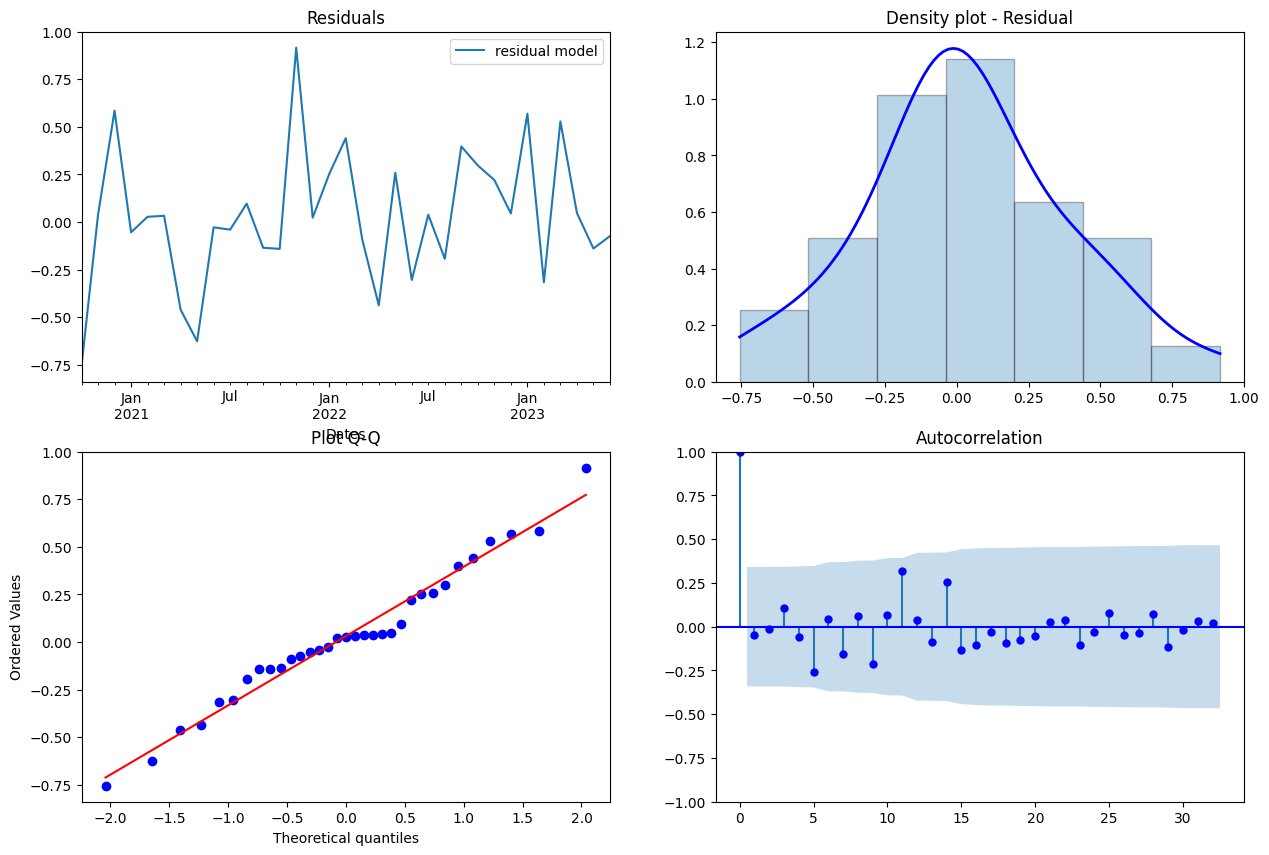

In [111]:
# visualize residuals of the model
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf

# extract residuals from the model
residual = pd.DataFrame(data=pmd_auto_arima_model.resid(), columns=['residual model'])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# Residual Plot
residual.plot(ax=axs[0,0])
axs[0,0].set_title('Residuals')

# Density
# plot the hist
axs[0,1].hist(residual, bins='auto', density=True, alpha=0.30, edgecolor='black')
# plot density curve
kde = stats.gaussian_kde(residual['residual model'])
x_range = np.linspace(min(residual['residual model']), max(residual['residual model']), 100)
axs[0,1].plot(x_range, kde(x_range), linewidth=2, color='blue')
axs[0,1].set_title("Density plot - Residual")

# Q-Q plot
stats.probplot(residual["residual model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# ACF plot
plot_acf(residual,  lags=len(residual)-1, ax=axs[1,1],color="blue")
axs[1,1].set_title("Autocorrelation")

plt.show()

Accuracy Metrics for pmd auto_arima - comparing to the previous Manually-developed SARIMA model

In [112]:
# define a function that computes accuracy metrics
forecasted_values = pmdarima_forecast
actual_values = X_val['Prices']

##############
def accuracy_metrics(actual_values, forecasted_values):
    # pre-process input df: only grab the rows in actual values that are aligned with the indices of the forecasted values
    forecasted_values = forecasted_values.dropna().copy(deep=True)
    actual_values = actual_values.iloc[-len(forecasted_values):].copy(deep=True) 
    # convert to arrays
    forecasted_values_arr = np.array(forecasted_values)
    actual_values_arr = np.array(actual_values)



    # compute the metrics and store in dict
    metrics_dict = {
        'MAE' : np.mean(np.abs(actual_values_arr - forecasted_values_arr)),
        'RMSE': np.sqrt( np.mean( (actual_values_arr - forecasted_values_arr)**2 ) ),
        'MAPE': np.mean( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'SMAPE': 100 * np.mean(2 * np.abs(actual_values_arr - forecasted_values_arr) / ( np.abs(actual_values_arr) + np.abs(forecasted_values_arr) )  ),
        'MdAPE': np.median( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'GMRAE': np.exp( np.mean( np.log( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) ) ) ) 

    }

    # returns a df
    return pd.DataFrame(index=metrics_dict.keys(), data=metrics_dict.values(), columns=['accuracy metrics'])



pmdarima_AM = accuracy_metrics(actual_values, forecasted_values)

# percent difference from SARIMA model
AM_diff_df = (pmdarima_AM - SARIMA_AM) / SARIMA_AM *100

# consolidate and compare
AM_consolidate_df = pd.concat([pmdarima_AM,SARIMA_AM,AM_diff_df], axis=1)
AM_consolidate_df.columns = ['pmdarima AM','SARIMA AM', '%_diff']
display(AM_consolidate_df)

,pmdarima AM,SARIMA AM,%_diff
MAE,0.831671,0.405983,104.853614
RMSE,0.899126,0.496234,81.190096
MAPE,6.885670,3.350591,105.506106
SMAPE,7.167325,3.386457,111.646735
MdAPE,6.708153,2.477832,170.726741
GMRAE,0.063828,0.024117,164.657908


Impose parameter constraints (parameters from the Manually-developed SARIMA model) to the auto_arima model

C:\Users\jpkdu\AppData\Local\Temp\ipykernel_14800\2348198711.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['time index'] = range(0, len(X_train)) # create integer time index for X_train
C:\Users\jpkdu\AppData\Local\Temp\ipykernel_14800\2348198711.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['trend'] = linear_reg_model2.predict(X_train[['time index']])


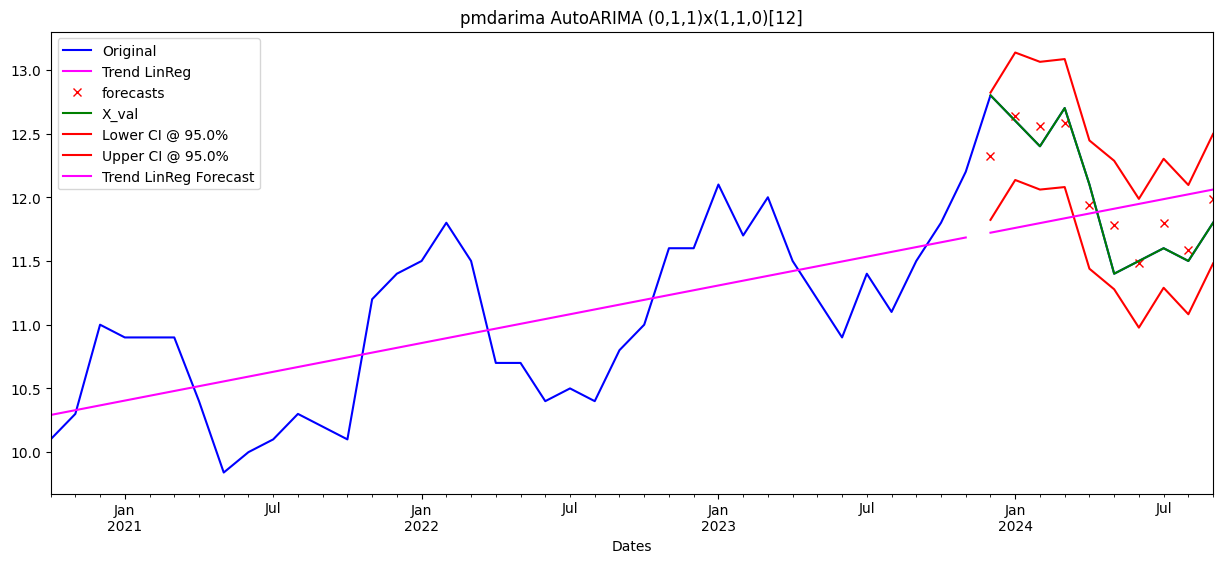

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   38
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                  -3.783
Date:                             Wed, 05 Feb 2025   AIC                             13.566
Time:                                     20:29:31   BIC                             17.223
Sample:                                 10-31-2020   HQIC                            14.580
                                      - 11-30-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9362      0.516     -1.814      0.070      -1.947       0.075
ar.S.L12      -0.4657      0.301     -1.548      0.122      -1.055       0.124
sigma2         0.0641      0.024      2.702      0.007       0.018       0.111
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.57   Prob(JB):                         0.90
Heteroskedasticity (H):               0.70   Skew:                            -0.13
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Correlation Matrix of Parameters


,ma.L1,ar.S.L12,sigma2
ma.L1,1.000000,-0.673284,0.191806
ar.S.L12,-0.673284,1.000000,0.211873
sigma2,0.191806,0.211873,1.000000


parameter/SE ratio


ma.L1       1.814489
ar.S.L12    1.547522
sigma2      2.701697
dtype: float64

In [114]:
# parameters to impose
p = 2; d = 1; q = 0; P = 0; D = 1; Q = 0; s = 12


# split dataset to training and validation
perc_train = 0.80 # define percentage of time series to be the training set and the rest will be the validating set
X_train = df.iloc[ : int(len(df)*perc_train ) ] #result._seasonal.iloc[ : int(len(df)*perc_train ) ] # # #
X_val = df.iloc[ int(len(df)*perc_train ) : ] #result._seasonal.iloc[ int(len(df)*perc_train ) : ] # # #

# train the ARIMA model
from pmdarima import auto_arima

pmd_auto_arima2 = auto_arima(X_train['Prices'], start_p=p, 
                                                 d=d, 
                                                 start_q=q, 
                                                 start_P=P,
                                                 D=D,
                                                 start_Q=Q,
                                                 max_p=2,
                                                 max_d=12,
                                                 max_q=2,
                                                 max_P=1,
                                                 max_D=1,
                                                 max_Q=1,
                                                 information_criterion='aic',
                                                 stepwise=True,
                                                 seasonal=True, m=12 )

# forecasting
h = len(X_val) # forecast horizon
alpha = 0.05 # significance level for confidence intervals
pmdarima_fc_summary_df = pmd_auto_arima2.arima_res_.get_forecast(h).summary_frame(alpha=alpha)
pmdarima_forecast = pmdarima_fc_summary_df['mean']


# for plotting trend with the forecasted data:
# Train a linear regression model with the X_train data
from sklearn.linear_model import LinearRegression
# define a linear regression model for the X_train data
linear_reg_model2 = LinearRegression()
# train a linear regression model with X_train data
X_train['time index'] = range(0, len(X_train)) # create integer time index for X_train
y_train = X_train['Prices']
linear_reg_model2.fit(X_train[['time index']], y_train)
# add the trend component to the X_train df for plotting purposes 
X_train['trend'] = linear_reg_model2.predict(X_train[['time index']])

# add the trend component to pmdarima forecast df for plotting purposes
last_time_index_of_X_train = len(X_train['trend'].index)
pmdarima_fc_summary_df['time index'] = range(last_time_index_of_X_train, last_time_index_of_X_train + len(pmdarima_fc_summary_df.index))
pmdarima_fc_summary_df['trend'] = linear_reg_model2.predict(pmdarima_fc_summary_df[['time index']])


# plot
plt.figure(figsize=(15,6))
 
result._observed.plot(kind='line', color='blue', label='Original') # plot original
#result._trend.plot(kind='line', color='black', label='Trend Decomp') # plot trend from decomposition
X_train['trend'].plot(kind='line', color='fuchsia', label='Trend LinReg') # plot trend from linear regression
pmdarima_forecast.plot(style='x', color='red', label='forecasts') # plot forecast
X_val['Prices'].plot(kind='line', color='green', label='X_val')
# extract confidence intervals and plot
pmdarima_fc_summary_df['mean_ci_lower'].plot(kind='line', color='red',label=f'Lower CI @ {100*(1-alpha)}% ') 
pmdarima_fc_summary_df['mean_ci_upper'].plot(kind='line', color='red',label=f'Upper CI @ {100*(1-alpha)}% ')
# trend line imposed on forecasts
pmdarima_fc_summary_df['trend'].plot(kind='line', color='fuchsia', label='Trend LinReg Forecast')


# extract parameters
p,d,q = pmd_auto_arima2.order
P,D,Q,s = pmd_auto_arima2.seasonal_order

plt.title(f'pmdarima AutoARIMA ({p},{d},{q})x({P},{D},{Q})[{s}]')
plt.legend()
plt.show()


# showing summary of outputs from the model
from IPython.display import display

display(pmd_auto_arima2.summary())


# print correlation matrix of parameters
cov_params_matrix = pmd_auto_arima2.arima_res_.cov_params()
std_devs = np.sqrt( np.diag(cov_params_matrix) )
corr_params_matrix = cov_params_matrix / np.outer(std_devs, std_devs)
print('Correlation Matrix of Parameters')
display(corr_params_matrix)

# print parameters/standard error (check if > 2 to be significant)
print('parameter/SE ratio')
display( np.abs(pmd_auto_arima2.arima_res_.params / pmd_auto_arima2.arima_res_.bse) )


# REMARKS:
# turns out that auto_arima found (0,1,1)x(1,1,0,12) to be the optimal parameters
# when forecasting beyond 1-year, it is observed that the forecasts would deviate above the trendline

Residual Analysis on the AutoARIMA model with imposed parameters

In [115]:
# obtain Ljung-Box test statistic and p-value
ljung_box_arr = pmd_auto_arima2.arima_res_.test_serial_correlation(method='ljungbox')

# extract statistic and p-value
ljung_box_extract = dict()
ljung_box_extract['Q-Statistic'] = ljung_box_arr.flatten()[0] # Q-statistic
ljung_box_extract['p-value'] = ljung_box_arr.flatten()[1]

# if p-value > 0.05, then fail to reject null hypothesis: errors/residuals follow white noise process (i.e. the errors are random or uncorrelated)
if ljung_box_extract['p-value'] > 0.05:
    ljung_box_extract['result'] = 'Errors are random'
else:
    ljung_box_extract['result'] = 'Errors are not random'


# obtain Box-Pierce test statistic and p-value
box_pierce_arr = pmd_auto_arima2.arima_res_.test_serial_correlation(method='boxpierce')

# extract statistic and p-value
box_pierce_extract = dict()
box_pierce_extract['Q-Statistic'] = box_pierce_arr.flatten()[0] # Q-statistic
box_pierce_extract['p-value'] = box_pierce_arr.flatten()[1]

# if p-value > 0.05, then fail to reject null hypothesis: errors/residuals follow white noise process (i.e. errors/residuals follow white noise process (i.e. the errors are random or uncorrelated)
if box_pierce_extract['p-value'] > 0.05:
    box_pierce_extract['result'] = 'Errors are random'
else:
    box_pierce_extract['result'] = 'Errors are not random'


lj_df = pd.DataFrame(data=ljung_box_extract.values(), index=ljung_box_extract.keys(), columns=['Ljung Box'])
bp_df = pd.DataFrame(data=box_pierce_extract.values(), index=box_pierce_extract.keys(), columns=['Box Pierce'])

residual_analysis_df = pd.concat([lj_df,bp_df], axis=1)
residual_analysis_df

,Ljung Box,Box Pierce
Q-Statistic,0.329706,0.293072
p-value,0.42435,0.373694
result,Errors are random,Errors are random


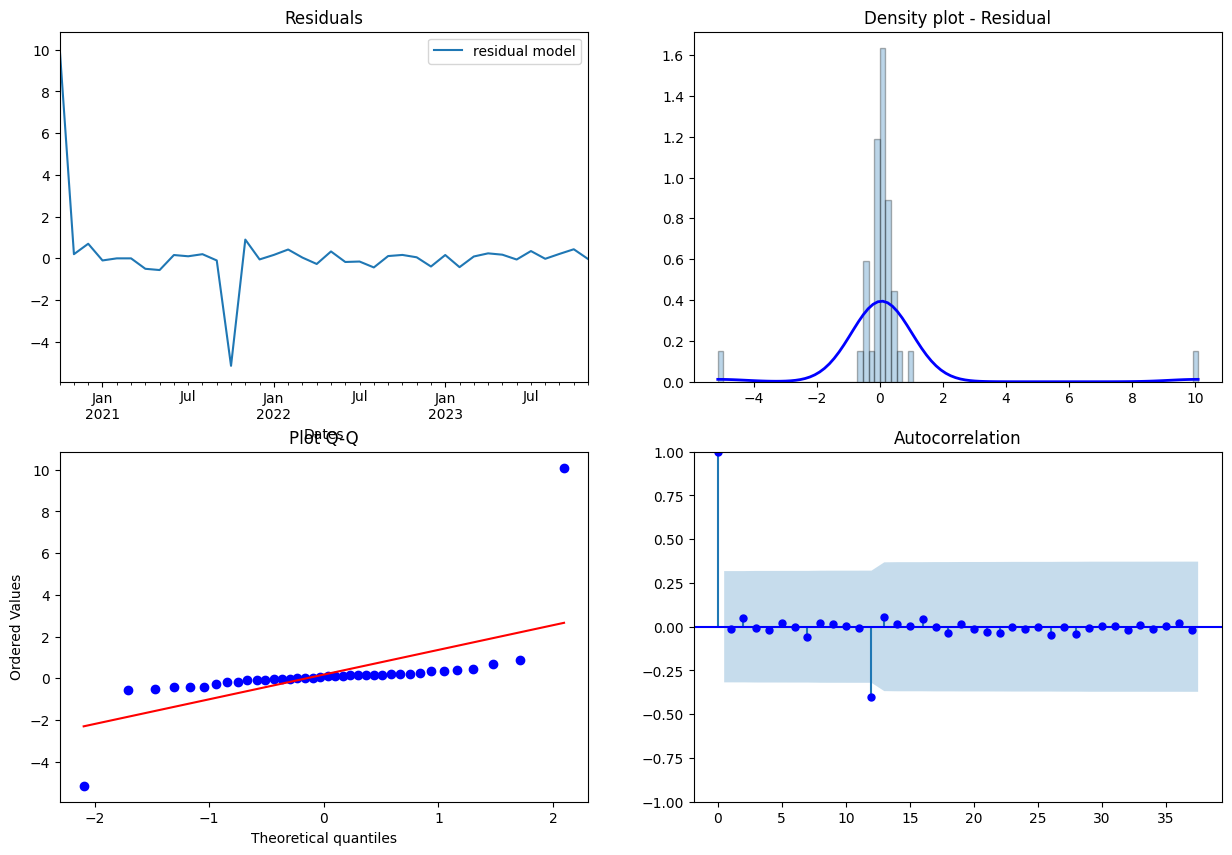

In [116]:
# visualize residuals of the model
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf

# extract residuals from the model
residual = pd.DataFrame(data=pmd_auto_arima2.resid(), columns=['residual model'])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# Residual Plot
residual.plot(ax=axs[0,0])
axs[0,0].set_title('Residuals')

# Density
# plot the hist
axs[0,1].hist(residual, bins='auto', density=True, alpha=0.30, edgecolor='black')
# plot density curve
kde = stats.gaussian_kde(residual['residual model'])
x_range = np.linspace(min(residual['residual model']), max(residual['residual model']), 100)
axs[0,1].plot(x_range, kde(x_range), linewidth=2, color='blue')
axs[0,1].set_title("Density plot - Residual")

# Q-Q plot
stats.probplot(residual["residual model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# ACF plot
plot_acf(residual,  lags=len(residual)-1, ax=axs[1,1],color="blue")
axs[1,1].set_title("Autocorrelation")

plt.show()

Accuracy Metrics for AutoARIMA with imposed parameters

In [118]:
# define a function that computes accuracy metrics
forecasted_values = pmdarima_forecast
actual_values = X_val['Prices']

##############
def accuracy_metrics(actual_values, forecasted_values):
    # pre-process input df: only grab the rows in actual values that are aligned with the indices of the forecasted values
    forecasted_values = forecasted_values.dropna().copy(deep=True)
    actual_values = actual_values.iloc[-len(forecasted_values):].copy(deep=True) 
    # convert to arrays
    forecasted_values_arr = np.array(forecasted_values)
    actual_values_arr = np.array(actual_values)



    # compute the metrics and store in dict
    metrics_dict = {
        'MAE' : np.mean(np.abs(actual_values_arr - forecasted_values_arr)),
        'RMSE': np.sqrt( np.mean( (actual_values_arr - forecasted_values_arr)**2 ) ),
        'MAPE': np.mean( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'SMAPE': 100 * np.mean(2 * np.abs(actual_values_arr - forecasted_values_arr) / ( np.abs(actual_values_arr) + np.abs(forecasted_values_arr) )  ),
        'MdAPE': np.median( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'GMRAE': np.exp( np.mean( np.log( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) ) ) ) 

    }

    # returns a df
    return pd.DataFrame(index=metrics_dict.keys(), data=metrics_dict.values(), columns=['accuracy metrics'])



constrained_pmdarima_AM = accuracy_metrics(actual_values, forecasted_values)

# percent difference from SARIMA model
AM_diff_df = (constrained_pmdarima_AM - SARIMA_AM) / SARIMA_AM *100

# consolidate and compare
AM_consolidate_df = pd.concat([constrained_pmdarima_AM,SARIMA_AM,AM_diff_df], axis=1)
AM_consolidate_df.columns = ['constrained_AutoARIMA_AM','SARIMA AM', '%_diff']
display(AM_consolidate_df)

,constrained_AutoARIMA_AM,SARIMA AM,%_diff
MAE,0.182455,0.405983,-55.058380
RMSE,0.228707,0.496234,-53.911400
MAPE,1.512233,3.350591,-54.866697
SMAPE,1.511250,3.386457,-55.373723
MdAPE,1.302421,2.477832,-47.437055
GMRAE,0.010611,0.024117,-56.001839


Alternative Model: statsforecast AutoARIMA

This model automatically estimates the p,d,q,P,D,Q,s parameters for us

c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
C:\Users\jpkdu\AppData\Local\Temp\ipykernel_14800\47115292.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['time index'] = range(0, len(X_train)) # create integer time index for X_train
C:\Users\jpkdu\AppData\Local\Temp\ipykernel_14800\47115292.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,coef
ar1,0.321382
ar2,0.18359
ar3,0.434148
sigma2,0.122532
AIC,22.352614
p,3
q,0
d,0
D,0
s,12


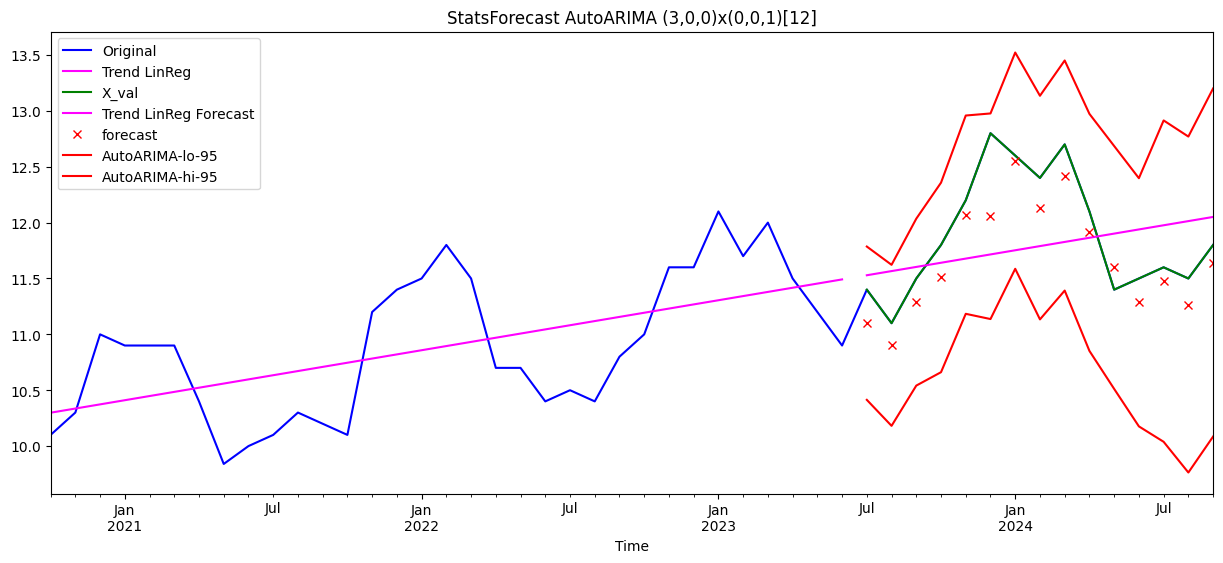

In [119]:
# input dataset needs to be processed in a specific format before feeding to StatsForecast
# reference: https://medium.com/towards-artificial-intelligence/can-machine-learning-outperform-statistical-models-for-time-series-forecasting-73dc2045a9c5
# tutorial: https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html

input_data_dict = {'unique_id': 'rev0',
                   'ds': df.index,
                    'y': df['Prices'] }
revised_df = pd.DataFrame(data=input_data_dict)

# split dataset to training and validation
perc_train = 0.70 # define percentage of time series to be the training set and the rest will be the validating set
X_train = revised_df.iloc[ : int(len(revised_df)*perc_train ) ] 
X_val = revised_df.iloc[ int(len(revised_df)*perc_train ) : ] 


# train the ARIMA model
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

sf_model = StatsForecast(models=[AutoARIMA(season_length=12)], freq='MS')
sf_model.fit(X_train)
# forecasting method 1
sf_forecast = sf_model.forecast(df=X_train ,h=len(X_val), level=[95], fitted=True)
# forecasting method 2
#sf_forecast = sf_model.predict(h=len(X_val), level=[95])

# revise output column names of the model
sf_forecast.rename(columns={'ds':'Time', 'AutoARIMA':'forecast'}, inplace=True) 

# convert the datetime to end of month days to be consistent with X_val datetime index
from pandas.tseries.offsets import MonthEnd
sf_forecast['Time'] = sf_forecast['Time'] + MonthEnd(0) # convert to End of Month
sf_forecast = sf_forecast.reset_index() # take out unique_id as index
sf_forecast = sf_forecast.set_index(sf_forecast['Time']) # set Time column as index
sf_forecast = sf_forecast.drop('Time', axis=1) # drops the Time columns

# for plotting trend with the forecasted data:
# Train a linear regression model with the X_train data
from sklearn.linear_model import LinearRegression
# define a linear regression model for the X_train data
linear_reg_model2 = LinearRegression()
# train a linear regression model with X_train data
X_train['time index'] = range(0, len(X_train)) # create integer time index for X_train
y_train = X_train['y']
linear_reg_model2.fit(X_train[['time index']], y_train)
# add the trend component to the X_train df for plotting purposes 
X_train['trend'] = linear_reg_model2.predict(X_train[['time index']])

# add the trend component to sf_forecast df for plotting purposes
last_time_index_of_X_train = len(X_train['trend'].index)
sf_forecast['time index'] = range(last_time_index_of_X_train, last_time_index_of_X_train + len(sf_forecast.index))
sf_forecast['trend'] = linear_reg_model2.predict(sf_forecast[['time index']])


# output summary
# extract model parameters

def auto_arima_summary(sf_model):

    model_params = sf_model.fitted_[0,0].model_

    # extract and convert as dataframes
    coef_df = pd.DataFrame(data=[model_params['coef'].keys(), model_params['coef'].values()], index=[None, 'coef']).transpose()
    sigma_df = pd.DataFrame(data=['sigma2', model_params['sigma2']], index=[None, 'coef']).transpose()
    aic_df = pd.DataFrame(data=['AIC', model_params['aic']], index=[None, 'coef']).transpose()

    param_df = pd.DataFrame(data=[ ['p','q','d','D','s','P','Q'], model_params['arma']]).transpose()
    param_df.columns = [None, 'coef']

    return pd.concat([coef_df,sigma_df,aic_df,param_df]).set_index(None)
    
auto_arima_output = auto_arima_summary(sf_model)
display(auto_arima_output)


p = auto_arima_output['coef'].loc['p']; d = auto_arima_output['coef'].loc['d']; q = auto_arima_output['coef'].loc['q'];
P = auto_arima_output['coef'].loc['P']; D = auto_arima_output['coef'].loc['D']; Q = auto_arima_output['coef'].loc['Q']


# plot
plt.figure(figsize=(15,6))
 
result._observed.plot(kind='line', color='blue', label='Original') # plot original
X_train['trend'].plot(kind='line', color='fuchsia', label='Trend LinReg') # plot trend from linear regression

X_val['y'].plot(kind='line', color='green', label='X_val') # plot trend from linear regression
sf_forecast['trend'].plot(kind='line', color='fuchsia', label='Trend LinReg Forecast') # plot trend from linear regression
sf_forecast['forecast'].plot(style='x', color='red') # plot forecast
sf_forecast['AutoARIMA-lo-95'].plot(kind='line', color='red') # low confidence interval
sf_forecast['AutoARIMA-hi-95'].plot(kind='line', color='red') # low confidence interval



plt.title(f'StatsForecast AutoARIMA ({p},{d},{q})x({P},{D},{Q})[{s}]')
plt.legend()
plt.show()

# REMARKS:
# this model is accurate for forecasting 1-year ahead
# however, beyond 1-year forecasting, the model deviates from the constant trend line

Residual Analysis

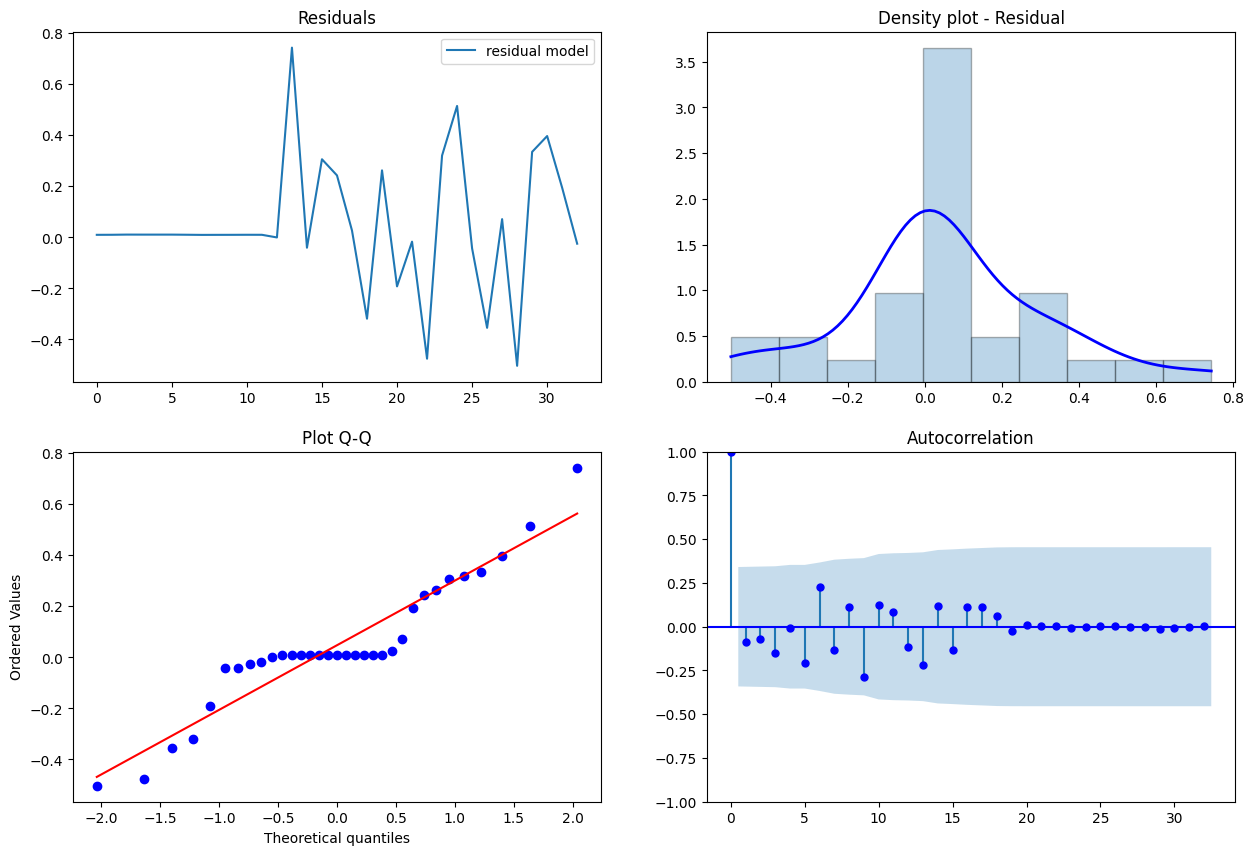

,Ljung-Box @ K=6
lb_stat,5.323838
lb_pvalue,0.502999
result,Errors are random


In [120]:
# RESIDUAL ANALYSIS
# visualize residuals of the model
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf

model_params = sf_model.fitted_[0,0].model_ # extract model outputs

residual = pd.DataFrame(data=model_params['residuals'], columns=['residual model']) # extract residuals

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))


# Residuals Plot
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals")

# Density
# plot the hist
axs[0,1].hist(residual, bins='auto', density=True, alpha=0.30, edgecolor='black')
# plot density curve
kde = stats.gaussian_kde(residual['residual model'])
x_range = np.linspace(min(residual['residual model']), max(residual['residual model']), 100)
axs[0,1].plot(x_range, kde(x_range), linewidth=2, color='blue')
axs[0,1].set_title("Density plot - Residual")

# Q-Q plot
stats.probplot(residual["residual model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# ACF plot
plot_acf(residual,  lags=len(residual)-1, ax=axs[1,1],color="blue")
axs[1,1].set_title("Autocorrelation")

plt.show()


# LJUNG-BOX TEST

from statsmodels.stats.diagnostic import acorr_ljungbox
# lag guidelines: 
# For non-seasonal time series Use h = min(10, T/5), where T is the number of observations
# For seasonal time series Use h = min(2m, T/5), where m is the seasonal period and T is the number of observations
h = int( min(10, len(residual)/5 ) )
ljung_box_extract = acorr_ljungbox(residual['residual model'], lags=h, return_df=True).iloc[-1] # extract the h-th lag

# if p-value > 0.05, then fail to reject null hypothesis: errors/residuals follow white noise process (i.e. the errors are random or uncorrelated)
if ljung_box_extract['lb_pvalue'] > 0.05:
    result_df = pd.DataFrame(data=['Errors are random'], index=['result'])
    summary_df = pd.concat([ljung_box_extract, result_df])
    summary_df.columns = [f'Ljung-Box @ K={h}']
    display( summary_df ) # display summary of results

else:
    result_df = pd.DataFrame(data=['Errors are random'], index=['result'])
    summary_df = pd.concat([ljung_box_extract, result_df])
    summary_df.columns = [f'Ljung-Box @ K={h}']
    display( summary_df ) # display summary of results

Accuracy Metrics for statsforecast AutoARIMA

In [121]:
# ACCURACY METRICS
# define a function that computes accuracy metrics
forecasted_values = sf_forecast['forecast']
actual_values = X_val['y']

##############
def accuracy_metrics(actual_values, forecasted_values):
    # pre-process input df: only grab the rows in actual values that are aligned with the indices of the forecasted values
    forecasted_values = forecasted_values.dropna().copy(deep=True)
    actual_values = actual_values.iloc[-len(forecasted_values):].copy(deep=True) 
    # convert to arrays
    forecasted_values_arr = np.array(forecasted_values)
    actual_values_arr = np.array(actual_values)



    # compute the metrics and store in dict
    metrics_dict = {
        'MAE' : np.mean(np.abs(actual_values_arr - forecasted_values_arr)),
        'RMSE': np.sqrt( np.mean( (actual_values_arr - forecasted_values_arr)**2 ) ),
        'MAPE': np.mean( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'SMAPE': 100 * np.mean(2 * np.abs(actual_values_arr - forecasted_values_arr) / ( np.abs(actual_values_arr) + np.abs(forecasted_values_arr) )  ),
        'MdAPE': np.median( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'GMRAE': np.exp( np.mean( np.log( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) ) ) ) 

    }

    # returns a df
    return pd.DataFrame(index=metrics_dict.keys(), data=metrics_dict.values(), columns=['accuracy metrics'])


sf_autoARIMA_AM = accuracy_metrics(actual_values, forecasted_values)

# percent difference from SARIMA model
AM_diff_df = (sf_autoARIMA_AM - SARIMA_AM) / SARIMA_AM *100

# consolidate and compare
AM_consolidate_df = pd.concat([sf_autoARIMA_AM,SARIMA_AM,AM_diff_df], axis=1)
AM_consolidate_df.columns = ['statsforecast AM','SARIMA AM', '%_diff']
display(AM_consolidate_df)


,statsforecast AM,SARIMA AM,%_diff
MAE,0.238330,0.405983,-41.295520
RMSE,0.281865,0.496234,-43.199195
MAPE,1.989761,3.350591,-40.614620
SMAPE,2.014830,3.386457,-40.503310
MdAPE,1.839923,2.477832,-25.744614
GMRAE,0.017120,0.024117,-29.012068


Alternative Model: AutoGluon

This is a Machine-Learning based time-series model

Pre-processing raw time-series

In [122]:
# REFERENCE: https://auto.gluon.ai/dev/tutorials/timeseries/forecasting-indepth.html

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# revise the raw time series to the format expected by AutoGluon TS

ag_df = df.copy(deep=True).reset_index() # reset datetime index
ag_df = ag_df.drop('time index', axis=1) # drop time index column
ag_df['item_id'] = ['rev0' for x in range(0, len(ag_df))] # item id column
ag_df = ag_df.rename(columns={'Dates':'timestamp','Prices':'target'}) # rename columns
ag_df.head()


,timestamp,target,item_id
0,2020-10-31,10.1,rev0
1,2020-11-30,10.3,rev0
2,2020-12-31,11.0,rev0
3,2021-01-31,10.9,rev0
4,2021-02-28,10.9,rev0


In [123]:
# convert the dataframe to the AutoGluon format using the following method
ag_formatted_df = TimeSeriesDataFrame.from_data_frame(ag_df,
                                                 id_column='item_id',
                                                 timestamp_column='timestamp' )

ag_formatted_df.head()

target
item_id timestamp         
rev0    2020-10-31    10.1
        2020-11-30    10.3
        2020-12-31    11.0
        2021-01-31    10.9
        2021-02-28    10.9

Split training and validation dataset

In [124]:
# split original time series to training and validation data
perc_train = 0.70 # define percentage of time series to be the training set and the rest will be the validating set
X_train = ag_formatted_df.iloc[ : int(len(ag_formatted_df)*perc_train ) ] 
X_val = ag_formatted_df.iloc[ int(len(ag_formatted_df)*perc_train ) :  ]

Fitting training dataset to a predictor model

In [125]:
# instantiate AutoGluon predictor model
AG_model = TimeSeriesPredictor(
                                prediction_length=len(X_val), # forecast horizon 
                                target='target',
                                eval_metric='RMSE'
)

# fit the model with training data
AG_model.fit(
            train_data=X_train,
            presets='best_quality',
            time_limit=1000,
)

Beginning AutoGluon training... Time limit = 1000s
AutoGluon will save models to 'c:\Users\jpkdu\Documents\GitHub\FinancialEngineering\JPMorgan - Quant Research\Task 1\AutogluonModels\ag-20250206_045940'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
GPU Count:          0
Memory Avail:       2.20 GB / 15.68 GB (14.0%)
Disk Space Avail:   8.63 GB / 475.97 GB (1.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 15,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selectio

Validation - visualizing predicted against validation set

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2        0.3        0.4  \
item_id timestamp                                                           
rev0    2023-07-31  11.111760  10.267921  10.688493  10.805461  11.049466   
        2023-08-31  11.060647  10.156319  10.583353  10.717814  10.968362   
        2023-09-30  11.242767  10.278137  10.697081  10.851078  11.129578   
        2023-10-31  11.390373  10.393330  10.776264  10.974793  11.268151   
        2023-11-30  11.735144  10.698200  11.080840  11.304960  11.630251   

                          0.5        0.6        0.7        0.8        0.9  
item_id timestamp                                                          
rev0    2023-07-31  11.115365  11.202495  11.290789  11.589509  11.949043  
        2023-08-31  11.054621  11.137355  11.230485  11.557647  11.949981  
        2023-09-30  11.229736  11.341975  11.430526  11.758708  12.173726  
        2023-10-31  11.353862  11.498564  11.609540  11.889611  12.272783  
        2023-11-30  11.711814  11.867130  11.998728  12.211165  12.559859

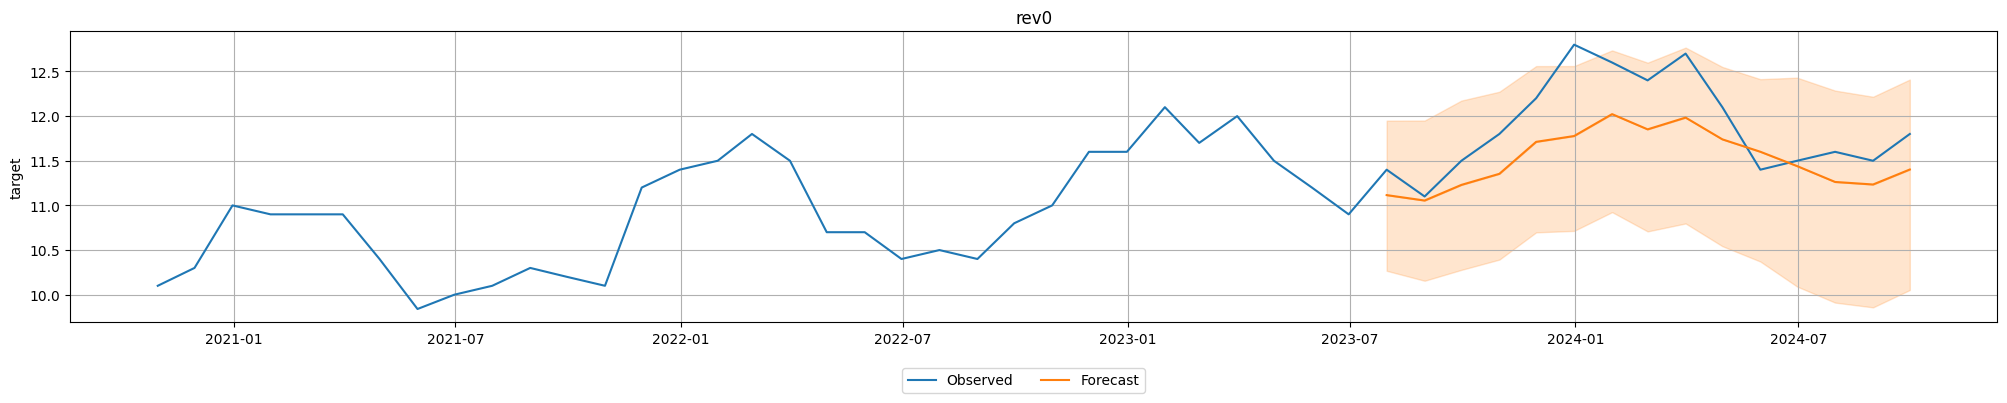

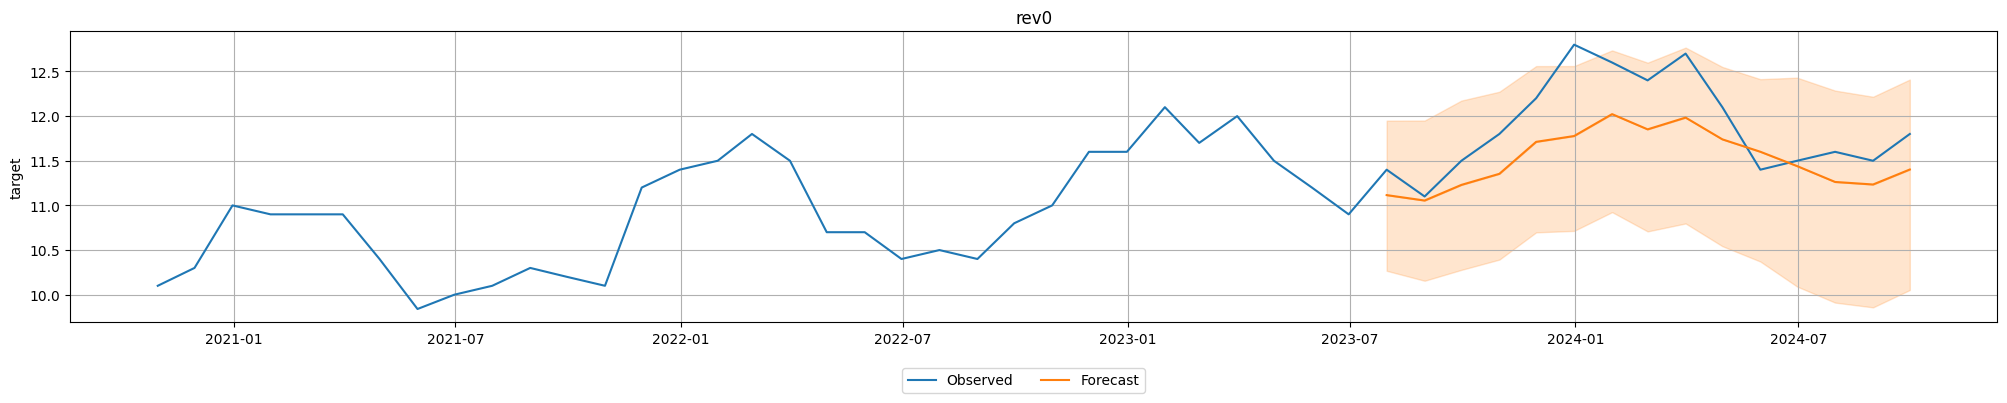

In [126]:
# forecast on validation data
# NOTE: In pmdarima, the input for forecasting is just the forecast horizon. For AutoGluon, it is found that X_train should be the input for the predict method
forecast_df = AG_model.predict(X_train) 
display(forecast_df.head())

# plot 
import matplotlib.pyplot as plt

AG_model.plot(pd.concat([X_train, X_val]), forecast_df, quantile_levels=[0.10, 0.90] )


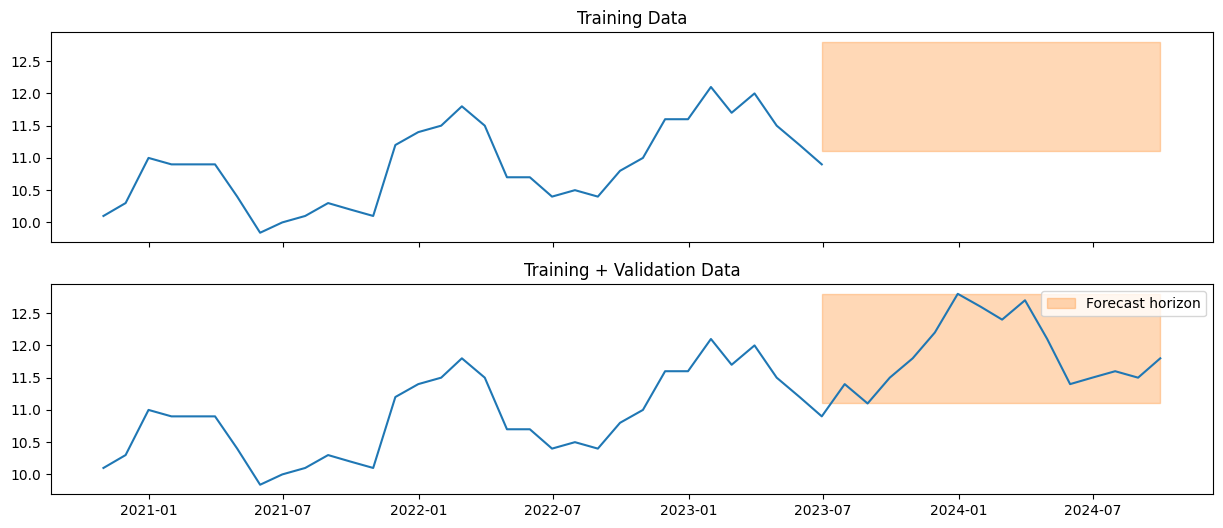

In [127]:
# alterantive plotting as shown in the AutoGluon documentation

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[15,6], sharex=True)
ax1.set_title('Training Data')
ax1.plot(X_train.loc['rev0'])

ax2.set_title('Training + Validation Data')
ax2.plot(pd.concat( [X_train.loc['rev0'], X_val.loc['rev0']] ))

for ax in (ax1, ax2):
    ax.fill_between(np.array([X_train.loc['rev0'].index[-1], X_val.loc['rev0'].index[-1]]), X_val.loc['rev0'].min(), X_val.loc['rev0'].max(), color="C1", alpha=0.3, label="Forecast horizon")
plt.legend()
plt.show()

Accuracy Metrics

In [130]:
# ACCURACY METRICS
# define a function that computes accuracy metrics
forecasted_values = forecast_df.loc['rev0']['mean']
actual_values = X_val.loc['rev0']['target']

##############
def accuracy_metrics(actual_values, forecasted_values):
    # pre-process input df: only grab the rows in actual values that are aligned with the indices of the forecasted values
    forecasted_values = forecasted_values.dropna().copy(deep=True)
    actual_values = actual_values.iloc[-len(forecasted_values):].copy(deep=True) 
    # convert to arrays
    forecasted_values_arr = np.array(forecasted_values)
    actual_values_arr = np.array(actual_values)



    # compute the metrics and store in dict
    metrics_dict = {
        'MAE' : np.mean(np.abs(actual_values_arr - forecasted_values_arr)),
        'RMSE': np.sqrt( np.mean( (actual_values_arr - forecasted_values_arr)**2 ) ),
        'MAPE': np.mean( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'SMAPE': 100 * np.mean(2 * np.abs(actual_values_arr - forecasted_values_arr) / ( np.abs(actual_values_arr) + np.abs(forecasted_values_arr) )  ),
        'MdAPE': np.median( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'GMRAE': np.exp( np.mean( np.log( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) ) ) ) 

    }

    # returns a df
    return pd.DataFrame(index=metrics_dict.keys(), data=metrics_dict.values(), columns=['accuracy metrics'])


AutoGluon_AM = accuracy_metrics(actual_values, forecasted_values)

# percent difference from SARIMA model
AM_diff_df = (AutoGluon_AM - SARIMA_AM) / SARIMA_AM *100

# consolidate and compare
AM_consolidate_df = pd.concat([AutoGluon_AM,SARIMA_AM,AM_diff_df], axis=1)
AM_consolidate_df.columns = ['AutoGluon AM','SARIMA AM', '%_diff']
display(AM_consolidate_df)


,AutoGluon AM,SARIMA AM,%_diff
MAE,0.393187,0.405983,-3.151790
RMSE,0.464462,0.496234,-6.402545
MAPE,3.230637,3.350591,-3.580085
SMAPE,3.300841,3.386457,-2.528164
MdAPE,2.994464,2.477832,20.850197
GMRAE,0.024995,0.024117,3.638612


Backtesting using multiple windows (aka Cross Validation)

In [131]:
# NOTE: this is similar to Cross Validation with rolling window

from autogluon.timeseries.splitter import ExpandingWindowSplitter

splitter = ExpandingWindowSplitter(prediction_length=len(X_val), num_val_windows=3)
for window_idx, (train_split, val_split) in enumerate(splitter.split( pd.concat( [X_train, X_val] ) )):
    score = AG_model.evaluate(val_split)
    print(f"Window {window_idx}: score = {score}")

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Window 0: score = {'RMSE': -0.4461449728493785}


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Window 1: score = {'RMSE': -0.19974845443342826}
Window 2: score = {'RMSE': -0.4644620010997451}


Utilize AutoGluon's automatic model selection capability

In [133]:
from autogluon.common import space

AG_manual_model = TimeSeriesPredictor(
                                        prediction_length=len(X_val), # forecast horizon
                                        target='target',
                                        eval_metric='RMSE'
)

AG_manual_model.fit(
                    train_data = X_train,
                    hyperparameters={
                        'AutoARIMAModel': {'d': space.Int(0,3), 'D': space.Int(0,1), 'seasonal':True, 'seasonal_period':12} 
                        #'ThetaModel':[ {"decomposition_type": "additive"}, {"seasonal_period": 1} ],
                        #'TemporalFusionTransformerModel':{},
                        #'ChronosModel':{}

                    },

                    hyperparameter_tune_kwargs='auto',
                    enable_ensemble=False
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\jpkdu\Documents\GitHub\FinancialEngineering\JPMorgan - Quant Research\Task 1\AutogluonModels\ag-20250206_051342'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
GPU Count:          0
Memory Avail:       1.33 GB / 15.68 GB (8.5%)
Disk Space Avail:   4.44 GB / 475.97 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': RMSE,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'AutoARIMAModel': {'D': Int: lower=0, upper=1,
                                        'd': Int: lower=0, upper=3,
                                        'seasonal': True,
                                        'seasonal_period': 12}},
 'known_covariates_names'

  0%|          | 0/10 [00:00<?, ?it/s]

	Trained 8 models while tuning AutoARIMA.
	-0.4002       = Validation score (-RMSE)
	6.63    s     = Total tuning time
Training complete. Models trained: ['AutoARIMA\\T1', 'AutoARIMA\\T2', 'AutoARIMA\\T3', 'AutoARIMA\\T4', 'AutoARIMA\\T5', 'AutoARIMA\\T6', 'AutoARIMA\\T7', 'AutoARIMA\\T8']
Total runtime: 6.94 s
Best model: AutoARIMA\T7
Best model score: -0.4002


Validation for the model selected by AutoGluon

Model not specified in predict, will default to the model with the best validation score: AutoARIMA\T7


mean        0.1        0.2        0.3        0.4  \
item_id timestamp                                                           
rev0    2023-07-31  11.019169  10.548321  10.709954  10.826502  10.926088   
        2023-08-31  10.907260  10.424400  10.590156  10.709678  10.811805   
        2023-09-30  11.315310  10.763078  10.952648  11.089341  11.206140   
        2023-10-31  11.509904  10.957459  11.147102  11.283848  11.400693   
        2023-11-30  12.113536  11.530927  11.730925  11.875137  11.998361   

                          0.5        0.6        0.7        0.8        0.9  
item_id timestamp                                                          
rev0    2023-07-31  11.019169  11.112250  11.211837  11.328385  11.490017  
        2023-08-31  10.907260  11.002716  11.104842  11.224364  11.390120  
        2023-09-30  11.315310  11.424479  11.541278  11.677971  11.867541  
        2023-10-31  11.509904  11.619116  11.735961  11.872707  12.062350  
        2023-11-30  12.113536  12.228710  12.351934  12.496147  12.696144

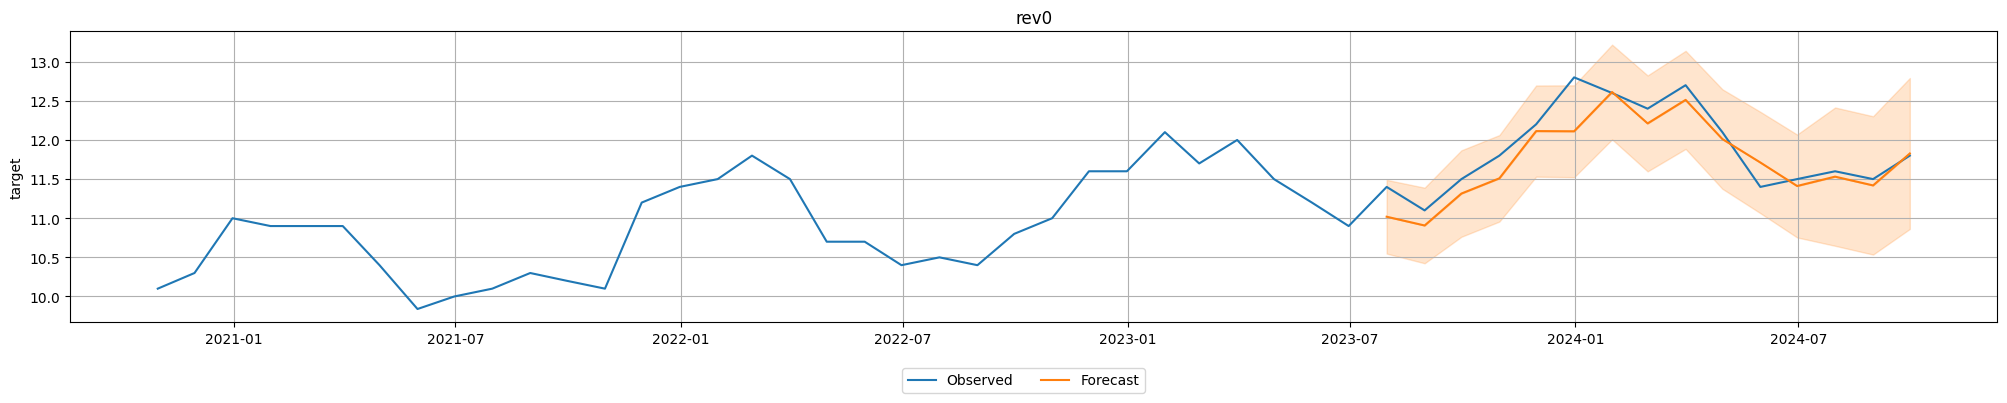

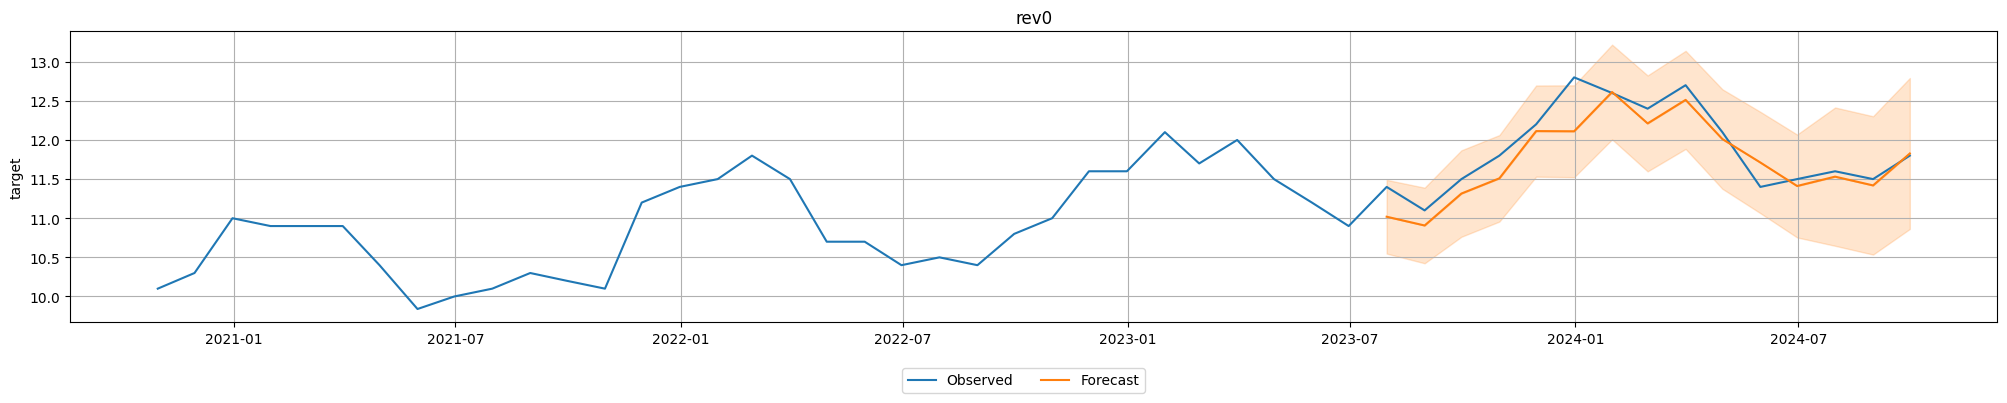

In [134]:
# forecast
forecast_AG_manual_df = AG_manual_model.predict(X_train)
display(forecast_AG_manual_df.head())

# plot
AG_manual_model.plot(pd.concat([X_train,X_val]), forecast_AG_manual_df, quantile_levels=[0.10, 0.90])

In [135]:
# extract the models that were trained
model_names = AG_manual_model._trainer.get_model_names()


# iterate through each model
for model_name in model_names:
    # load the model from the AG TSPredictor object
    model = AG_manual_model._trainer.load_model(model_name)
    print(f'model={model_name}, hyperparameters={ model.get_trained_params() }')

# REMARK: For AutoGluon, it seems impossible to access the best hyperparameters after tuning

model=AutoARIMA\T1, hyperparameters={'d': Int: lower=0, upper=3, 'D': Int: lower=0, upper=1, 'seasonal': True, 'seasonal_period': 12}
model=AutoARIMA\T2, hyperparameters={'d': Int: lower=0, upper=3, 'D': Int: lower=0, upper=1, 'seasonal': True, 'seasonal_period': 12}
model=AutoARIMA\T3, hyperparameters={'d': Int: lower=0, upper=3, 'D': Int: lower=0, upper=1, 'seasonal': True, 'seasonal_period': 12}
model=AutoARIMA\T4, hyperparameters={'d': Int: lower=0, upper=3, 'D': Int: lower=0, upper=1, 'seasonal': True, 'seasonal_period': 12}
model=AutoARIMA\T5, hyperparameters={'d': Int: lower=0, upper=3, 'D': Int: lower=0, upper=1, 'seasonal': True, 'seasonal_period': 12}
model=AutoARIMA\T6, hyperparameters={'d': Int: lower=0, upper=3, 'D': Int: lower=0, upper=1, 'seasonal': True, 'seasonal_period': 12}
model=AutoARIMA\T7, hyperparameters={'d': Int: lower=0, upper=3, 'D': Int: lower=0, upper=1, 'seasonal': True, 'seasonal_period': 12}
model=AutoARIMA\T8, hyperparameters={'d': Int: lower=0, upper=

In [136]:
AG_manual_model.leaderboard(X_train)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,AutoARIMA\T7,-0.400220,-0.400220,0.099362,2.202406,2.208511,7
1,AutoARIMA\T6,-0.661312,-0.661312,0.036295,0.038701,0.049195,6
2,AutoARIMA\T3,-0.684066,-0.684066,0.037528,0.040558,0.053558,3
3,AutoARIMA\T5,-0.684066,-0.684066,0.173960,0.142607,0.150607,5
4,AutoARIMA\T1,-0.710689,-0.710689,0.120184,0.944770,0.952664,1
5,AutoARIMA\T8,-1.110240,-1.110240,0.058621,2.135821,2.144935,8
6,AutoARIMA\T2,-8.007683,-8.007683,0.099172,0.089192,0.098315,2
7,AutoARIMA\T4,-38.882921,-38.882921,0.099858,0.862121,0.869126,4


Accuracy Metrics

In [138]:
# ACCURACY METRICS
# define a function that computes accuracy metrics
forecasted_values = forecast_AG_manual_df.loc['rev0']['mean']
actual_values = X_val.loc['rev0']['target']

##############
def accuracy_metrics(actual_values, forecasted_values):
    # pre-process input df: only grab the rows in actual values that are aligned with the indices of the forecasted values
    forecasted_values = forecasted_values.dropna().copy(deep=True)
    actual_values = actual_values.iloc[-len(forecasted_values):].copy(deep=True) 
    # convert to arrays
    forecasted_values_arr = np.array(forecasted_values)
    actual_values_arr = np.array(actual_values)



    # compute the metrics and store in dict
    metrics_dict = {
        'MAE' : np.mean(np.abs(actual_values_arr - forecasted_values_arr)),
        'RMSE': np.sqrt( np.mean( (actual_values_arr - forecasted_values_arr)**2 ) ),
        'MAPE': np.mean( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'SMAPE': 100 * np.mean(2 * np.abs(actual_values_arr - forecasted_values_arr) / ( np.abs(actual_values_arr) + np.abs(forecasted_values_arr) )  ),
        'MdAPE': np.median( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) )*100,
        'GMRAE': np.exp( np.mean( np.log( np.abs( (actual_values_arr - forecasted_values_arr)/actual_values_arr ) ) ) ) 

    }

    # returns a df
    return pd.DataFrame(index=metrics_dict.keys(), data=metrics_dict.values(), columns=['accuracy metrics'])


AutoGluon_manual_AM = accuracy_metrics(actual_values, forecasted_values)

# percent difference from SARIMA model
AM_diff_df = (AutoGluon_manual_AM - SARIMA_AM) / SARIMA_AM *100

# consolidate and compare
AM_consolidate_df = pd.concat([AutoGluon_manual_AM,SARIMA_AM,AM_diff_df], axis=1)
AM_consolidate_df.columns = ['AutoGluon Manual AM','SARIMA AM', '%_diff']
display(AM_consolidate_df)


,AutoGluon Manual AM,SARIMA AM,%_diff
MAE,0.191841,0.405983,-52.746599
RMSE,0.255386,0.496234,-48.535134
MAPE,1.605891,3.350591,-52.071427
SMAPE,1.623360,3.386457,-52.063159
MdAPE,1.477373,2.477832,-40.376385
GMRAE,0.010741,0.024117,-55.465137


Cross Validation - robust way to determine which SARIMA model that we have seen so far is best to use for forecasting

In [139]:
# REMARK: ValueError: Input contains NaN. is raised for certain ARIMA parameters

from pmdarima import model_selection
#import pmdarima as pm
from pmdarima import ARIMA, auto_arima

# split time series
perc_train = 0.70 # define percentage of time series to be the training set and the rest will be the validating set
X_train = df.iloc[ : int(len(df)*perc_train ) ] 
X_val = df.iloc[ int(len(df)*perc_train ) :  ]


# instantiate the ARIMA model parameters we have dealt above
model1 = ARIMA(order=(2,1,0), seasonal_order=(0,0,0,12)) # causes NaN errors: ARIMA(order=(2,1,0), seasonal_order=(0,0,0,12))
                                                         # I suspenct that it is caused by seasonal difference D=1 at s=12 that is applied to the small window size   
model2 = pmd_auto_arima_model
model3 = pmd_auto_arima2

# choose window size, step size, and forecasting horizon h for sliding and rolling CV methods
window_size = 12; step = 1; h = 1
cv_sliding = model_selection.SlidingWindowForecastCV(window_size=window_size, step=step, h=h)
cv_rolling = model_selection.RollingForecastCV(step=step, h=h)

# compute scores
model1_cvRolling_scores = model_selection.cross_val_score(estimator=model1, y=X_train['Prices'], scoring='smape', cv=cv_rolling, verbose=2)
model1_cvSliding_scores = model_selection.cross_val_score(model1, X_train['Prices'], scoring='smape', cv=cv_sliding, verbose=2)

model2_cvRolling_scores = model_selection.cross_val_score(estimator=model2, y=X_train['Prices'], scoring='smape', cv=cv_rolling, verbose=2)
model2_cvSliding_scores = model_selection.cross_val_score(model2, X_train['Prices'], scoring='smape', cv=cv_sliding, verbose=2)

model3_cvRolling_scores = model_selection.cross_val_score(estimator=model3, y=X_train['Prices'], scoring='smape', cv=cv_rolling, verbose=2)
model3_cvSliding_scores = model_selection.cross_val_score(model3, X_train['Prices'], scoring='smape', cv=cv_sliding, verbose=2)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................


c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\s

[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................


c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\s

[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=0 ..........................................................


c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\s

[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] f

c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\s

[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=0 ..........................................................


c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\s

[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] f

c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\model_selection\_validation.py:94: ModelFitWarning: Estimator fit failed. The score on this train-test partition will be set to nan. Details: 
IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

  warnings.warn("Estimator fit failed. The score on this train-test "


[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] f

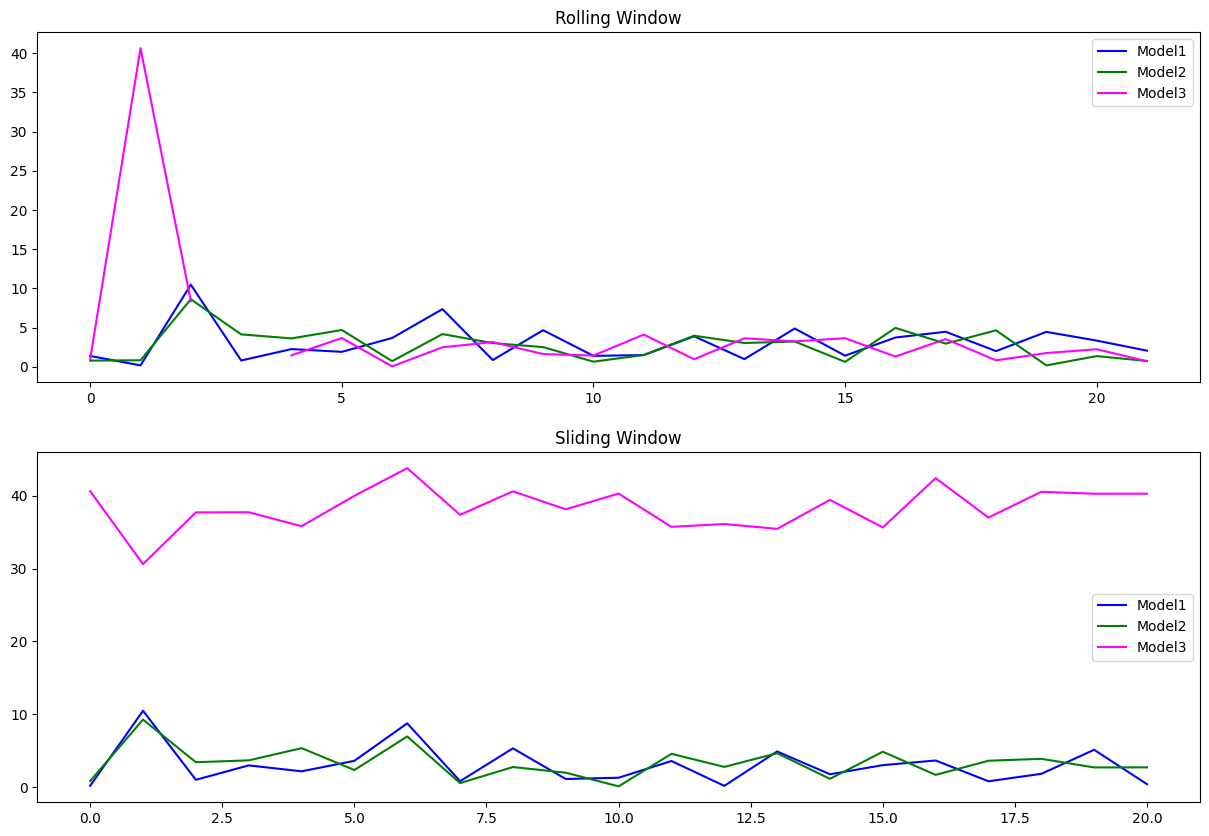

In [140]:
# plot the scores
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
# Model1
pd.DataFrame(model1_cvRolling_scores, columns=['Model1']).plot(ax=ax1, color='blue')
pd.DataFrame(model1_cvSliding_scores, columns=['Model1']).plot(ax=ax2, color='blue')
# Model2
pd.DataFrame(model2_cvRolling_scores, columns=['Model2']).plot(ax=ax1, color='green')
pd.DataFrame(model2_cvSliding_scores, columns=['Model2']).plot(ax=ax2, color='green')
# Model3
pd.DataFrame(model3_cvRolling_scores, columns=['Model3']).plot(ax=ax1, color='magenta')
pd.DataFrame(model3_cvSliding_scores, columns=['Model3']).plot(ax=ax2, color='magenta')


ax1.set_title('Rolling Window')
ax2.set_title('Sliding Window')


plt.legend()
plt.show()

Consolidated Accuracy Metrics from the models that we have seen so far

In [141]:
AM_consolidate_df = pd.concat([SARIMA_AM, 
                               arima_AM,
                               pmdarima_AM,
                               constrained_pmdarima_AM,
                               sf_autoARIMA_AM,
                               AutoGluon_AM,
                               AutoGluon_manual_AM
                               ], axis=1)

AM_consolidate_df.columns = ['SARIMA_AM',
                             'arima_AM', 
                             'pmdarima_AM', 
                             'constrained_pmdarima_AM',
                             'sf_autoARIMA_AM',
                             'AutoGluon_AM',
                             'AutoGluon_manual_AM']

AM_consolidate_df

,SARIMA_AM,arima_AM,pmdarima_AM,constrained_pmdarima_AM,sf_autoARIMA_AM,AutoGluon_AM,AutoGluon_manual_AM
MAE,0.405983,0.202615,0.831671,0.182455,0.238330,0.393187,0.191841
RMSE,0.496234,0.265367,0.899126,0.228707,0.281865,0.464462,0.255386
MAPE,3.350591,1.697513,6.885670,1.512233,1.989761,3.230637,1.605891
SMAPE,3.386457,1.717316,7.167325,1.511250,2.014830,3.300841,1.623360
MdAPE,2.477832,1.584939,6.708153,1.302421,1.839923,2.994464,1.477373
GMRAE,0.024117,0.008713,0.063828,0.010611,0.017120,0.024995,0.010741


Use pmdarima ARIMA model to forecast 1-year ahead

c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\jpkdu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\jpkdu\AppData\Local\Temp\ipykernel_14800\4200485413.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['trend'] = linear_reg_model.predict(X_train[['time index']])


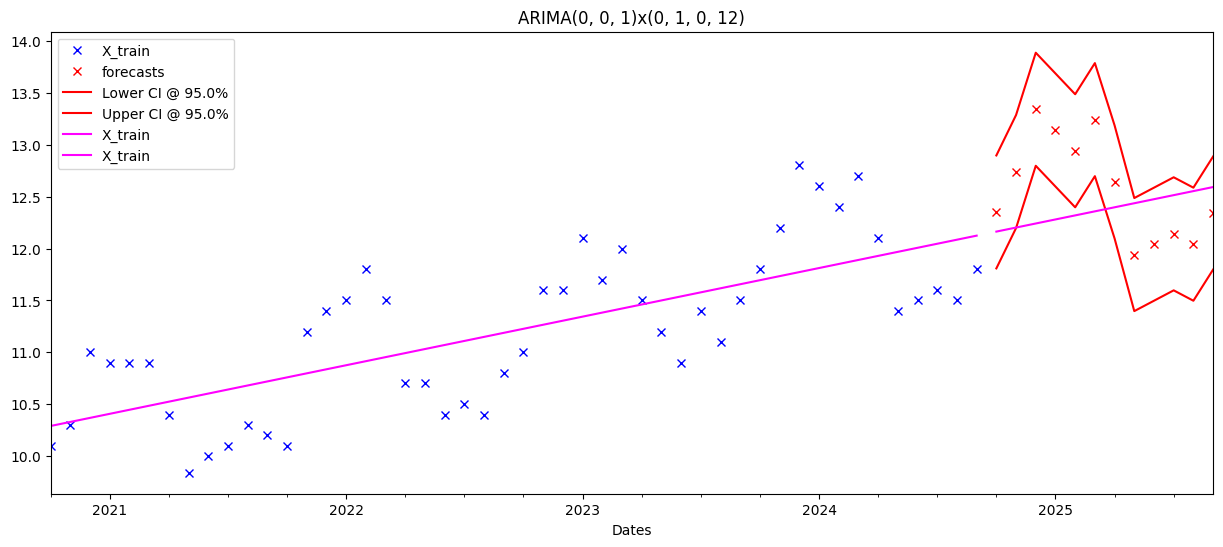

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                  -4.946
Date:                             Wed, 05 Feb 2025   AIC                             15.891
Time:                                     21:24:28   BIC                             20.642
Sample:                                 10-31-2020   HQIC                            17.549
                                      - 09-30-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5415      0.045     12.082      0.000       0.454       0.629
ma.L1         -0.0440      0.290     -0.152      0.879      -0.612       0.524
sigma2         0.0771      0.019      4.100      0.000       0.040       0.114
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.99   Prob(JB):                         0.93
Heteroskedasticity (H):               0.93   Skew:                            -0.15
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Correlation Matrix of Parameters


,intercept,ma.L1,sigma2
intercept,1.000000,0.071660,0.104954
ma.L1,0.071660,1.000000,-0.044129
sigma2,0.104954,-0.044129,1.000000


parameter/SE ratio


intercept    12.081862
ma.L1         0.151759
sigma2        4.100137
dtype: float64

In [ ]:
# use the pmdarima ARIMA model
from pmdarima import ARIMA

# we will now train the ARIMA model using the whole dataset
perc_train = 1 # define percentage of time series to be the training set and the rest will be the validating set
X_train = df.iloc[ : int(len(df)*perc_train ) ] 
#X_val = df.iloc[ int(len(df)*perc_train ) :  ]

# use the identified best parameters for this model
order = (0,0,1) # non-seasonal
seasonal_order = (0,1,0,12) # seasonal

# instantiate and fit the ARIMA model
arima_model = ARIMA(order=order, seasonal_order=seasonal_order)

# forecasting
h = 12 # extra 12months ahead of given data forecast horizon
alpha = 0.05 # significant level for confidence intervals
# extract forecasts and confidence intervals
arima_fc_summary_df = arima_model.fit(X_train['Prices']).arima_res_.get_forecast(h).summary_frame(alpha=alpha)
arima_forecast = arima_fc_summary_df['mean'] # extract forecasts

# fit the X_train with linear regression to depict as trend of the series
from sklearn.linear_model import LinearRegression
linear_reg_model = LinearRegression() # instantiate
# note that the original df has been imposed with integer time indices before splitting the dataset
linear_reg_model.fit(X=X_train[['time index']], y=X_train['Prices'])
# add the trend component to the X_train df for plotting purposes
X_train['trend'] = linear_reg_model.predict(X_train[['time index']])

# also impose the trend component to the arima_fc_summary_df for plotting purposes:
# noting the last index of X_train
last_time_index_of_X_train = len(X_train['trend'].index)
# impose integer time indices to the pmdarima_fc_summary_df continuing the count from the last index of X_train
arima_fc_summary_df['time index'] = range(last_time_index_of_X_train, last_time_index_of_X_train + len(arima_fc_summary_df))
arima_fc_summary_df['trend'] = linear_reg_model.predict( arima_fc_summary_df[['time index']] )

# plotting
plt.figure(figsize=(15,6))
# plot training & validation data
X_train['Prices'].plot(style='x', color='blue', label='X_train')
#X_val['Prices'].plot(kind='line', color='green', label='X_val')
# plot forecasts and confidence intervals
arima_fc_summary_df['mean'].plot(style='x', color='red', label='forecasts')
arima_fc_summary_df['mean_ci_lower'].plot(kind='line', color='red', label=f'Lower CI @ {(1-alpha)*100}%')
arima_fc_summary_df['mean_ci_upper'].plot(kind='line', color='red', label=f'Upper CI @ {(1-alpha)*100}%')
# impose trend line on both training and validation data
X_train['trend'].plot(kind='line', color='fuchsia', label='X_train')
arima_fc_summary_df['trend'].plot(kind='line', color='fuchsia', label='X_train')


plt.title(f'ARIMA{order}x{seasonal_order}') 
plt.legend()
plt.show()


# showing summary of outputs from the model
from IPython.display import display

display(arima_model.summary())


# print correlation matrix of parameters
cov_params_matrix = arima_model.arima_res_.cov_params()
std_devs = np.sqrt( np.diag(cov_params_matrix) )
corr_params_matrix = cov_params_matrix / np.outer(std_devs, std_devs)
print('Correlation Matrix of Parameters')
display(corr_params_matrix)

# print parameters/standard error (check if > 2 to be significant)
print('parameter/SE ratio')
display( np.abs(arima_model.arima_res_.params / arima_model.arima_res_.bse) )




Create a pricing function that will output Natural Gas Contract Price given an input end-of-month date

In [143]:
# combine the training data and the forecasts into a consolidated lookup df
train_df = arima_model.predict_in_sample() # model estimates of the training data "predict/forecast the sample"
pred_df = arima_model.predict(X=h) # predicted/forecasted df 

lookup_df = pd.concat([X_train['Prices'],train_df], axis=1) # consolidate the df

# fixes the erroneous in-sample predictions by copying a slice of the original series in lieu of the erroneous data
lookup_df.loc[:'2021-09-30','predicted_mean'] = lookup_df.loc[:'2021-09-30']['Prices']
# drops the column of the original data
lookup_df = lookup_df.drop(columns=['Prices'])


# function that converts string user-input dates into datetime objects
from datetime import date

def NG_price_lookup(lookup_df, user_date):

    return lookup_df.loc[pd.Timestamp(user_date)].iloc[0]

# do a sample lookup
NG_price_lookup(lookup_df, date(2022,1,31))


11.447071543780456

Extend the pricing function to output Natural Gas Contract Price given a daily date i.e. given monthly dataset, interpolate daily datapoints in-between monthly datapoints

In [144]:
# will need to interpolate the NaNs shown below
lookup_df.resample('D').asfreq()

,predicted_mean
2020-10-31,10.100000
2020-11-01,NaN
2020-11-02,NaN
2020-11-03,NaN
2020-11-04,NaN
...,...
2024-09-26,NaN
2024-09-27,NaN
2024-09-28,NaN
2024-09-29,NaN


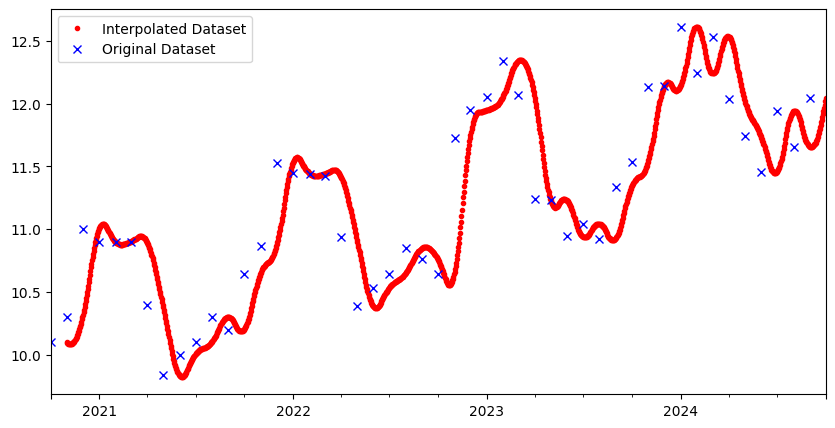

In [145]:
# resample and interpolate using a chosen method
interpolated_lookup_df = lookup_df.resample('D').interpolate(method='polynomial', order=2)

plt.figure(figsize=(10,5))
interpolated_lookup_df.plot(color='red', ax=plt.gca(), style='.')
lookup_df.plot(color='blue', ax=plt.gca(), style='x')

plt.legend(labels=['Interpolated Dataset', 'Original Dataset'])


In [146]:
# can now do a lookup for any date up until the last forecast date
NG_price_lookup(interpolated_lookup_df, date(2022,1,31))

11.447071543780456

<span style="font-size: 30px">Part 2: Enhanced Pricing Model to that Accounts for Costs</span>

<span style="font-size: 20px">JPMorgan Quant Research Project via Forage</span>

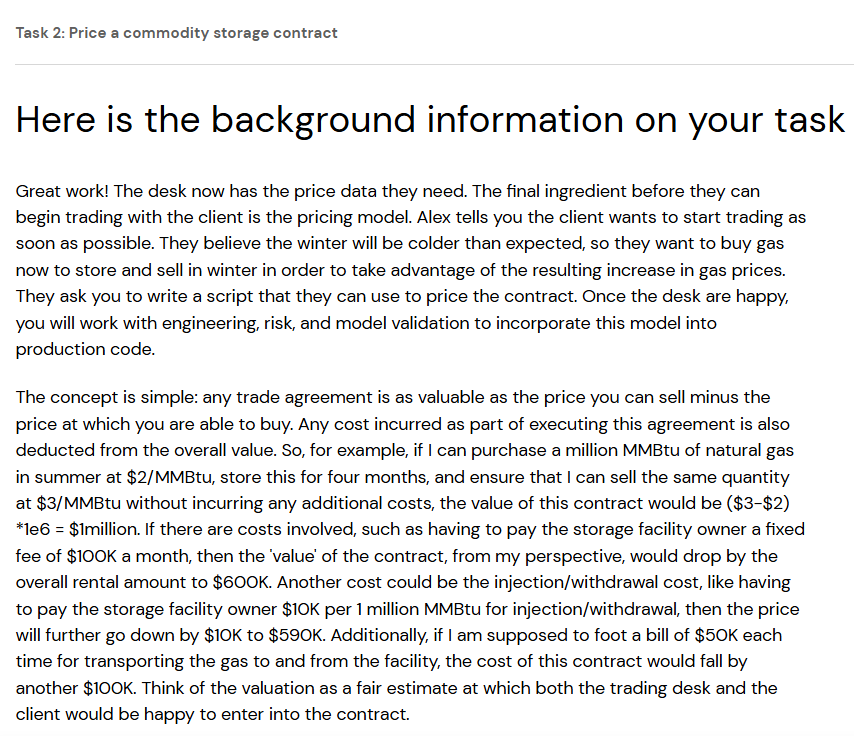

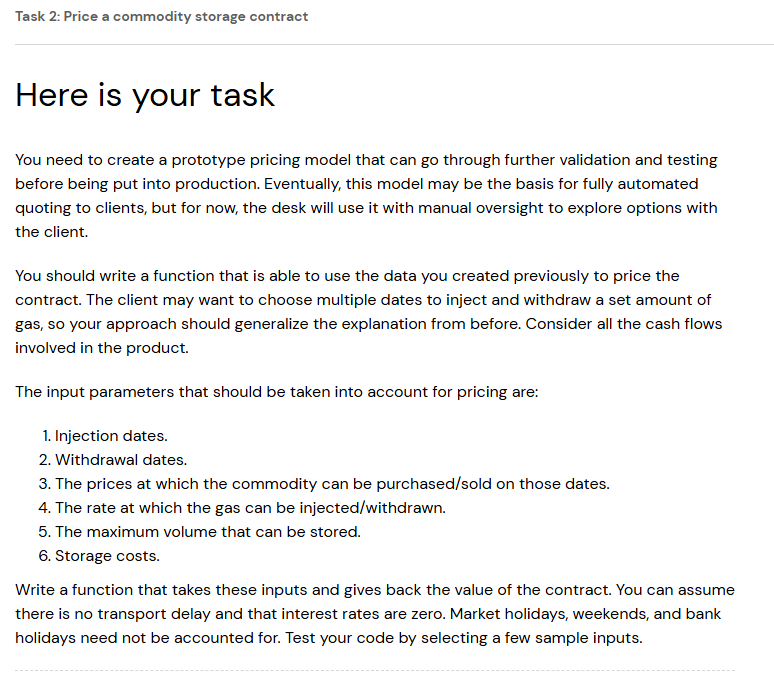

In [147]:
# define the enhanced pricing function
def NG_pricing_model(injection_dates, withdrawal_dates, injection_prices, withdrawal_prices, rate, inj_withd_cost_rate, storage_cost, max_storage_volume):

    # create a dictionary for date-price pair
    date_price_dict = dict( zip(injection_dates + withdrawal_dates, injection_prices + withdrawal_prices) )

    # initialize
    stored_volume = 0.0 # tracks the volume of gas that is being stored 
    buy_cost = 0.0 # tracks cash used to buy gas
    cash_received = 0.0 # tracks cash proceeds from gas at withdrawal dates

    # put the injection and withdrawal dates in sequence
    sorted_dates = sorted(injection_dates + withdrawal_dates)

    # iterate through the dates: 
    for i_date in sorted_dates:
        # if injection date
        if i_date in injection_dates:
            # checks if the current stored volume will not exceed the max storage volume when injected at daily rate
            if stored_volume <=  max_storage_volume - rate:
                stored_volume += rate # injects gas to storage at the daily rate

                # cost to purchase gas per volume
                buy_cost += rate * date_price_dict[i_date]

                # injection cost
                buy_cost += rate * inj_withd_cost_rate

                print(f'Injected gas on {i_date} at the price of {date_price_dict[i_date]}; current stored volume = {stored_volume}')

            else:
                # exceeds max storage volume
                print(f'Cannot inject more gas since current stored volume = {stored_volume} will exceed max storage volume = {max_storage_volume}')

        # if withdrawal date
        elif i_date in withdrawal_dates:
            # checks if the current stored volume has enough to withdraw at daily rate
            if stored_volume >= rate:
                stored_volume -= rate # withdraw gas from storage at the daily rate

                # withdrawal cost
                withdrawal_cost = rate * inj_withd_cost_rate

                # proceeds received minus withdrawal cost
                cash_received += rate * date_price_dict[i_date] 
                cash_received -= withdrawal_cost

                print(f'Extracted gas on {i_date} at the price of {date_price_dict[i_date]}; current stored volume = {stored_volume}')

            else:
                # not enough stored gas to withdraw at daily rate
                print(f'Cannot extract gas since current stored volume = {stored_volume} cannot withdraw at the daily volume rate = {rate}')


    # computing storage cost
    state = 0 # tracks states: 0:look-for-inject-date, 1:look-for-extract-date
    num_consecutive_extract_date = 0 # tracks the number of consecutive extract dates found
    found_inj_date = date(2024,1,1) # tracks identified injection date
    duration = 0 # tracks the sum of duration of time in-between injection date and extraction date in days


    # iterate through the injection and withdrawal dates in sequence
    for i_date in sorted_dates:

        # print(f'i_date={i_date}, state={state}, found_inj_date={found_inj_date}, num_consecutive_extract_date={num_consecutive_extract_date}, duration={duration} ')
        # if look-for-inject-date state
        if state == 0:
            if i_date in injection_dates:
                found_inj_date = i_date # store the injection date
                num_consecutive_extract_date += 1 # add counter for each injection date found
                state = 1 # change to look for look-for-extract-date

            elif i_date in withdrawal_dates:
                num_consecutive_extract_date -= 1 # subtract counter for each withdrawal date found

                if num_consecutive_extract_date == 0:
                    # calculates the length of days in-between and add to duration
                    duration += (i_date - found_inj_date).days


        # if in look-for-extract-date state
        elif state == 1:
            if i_date in withdrawal_dates:
                state = 0 # change to look-for-inject-date
                num_consecutive_extract_date -= 1 # subtract counter for each withdrawal date found

                if num_consecutive_extract_date == 0:
                    # calculates the length of days in-between and add to duration
                    duration += (i_date - found_inj_date).days

            elif i_date in injection_dates:
                num_consecutive_extract_date += 1 # add counter for each injection date found


    gross_storage_cost = (duration / 30) * storage_cost

    # return final cash value
    #print(f'Final Contract Value ${round(cash_received - buy_cost - gross_storage_cost,2)}')
    contract_price = round(cash_received - buy_cost - gross_storage_cost,2)
    return (contract_price, round(cash_received,2), round(buy_cost,2), round(gross_storage_cost,2))




Injected gas on 2021-05-01 at the price of 10.379119180285496; current stored volume = 100000.0
Injected gas on 2021-06-01 at the price of 9.83474385443504; current stored volume = 200000.0
Injected gas on 2021-07-01 at the price of 10.00565758886882; current stored volume = 300000.0
Injected gas on 2021-08-01 at the price of 10.105600036555678; current stored volume = 400000.0
Extracted gas on 2023-11-01 at the price of 11.548990135997904; current stored volume = 300000.0
Extracted gas on 2023-12-01 at the price of 12.138981571996267; current stored volume = 200000.0
Extracted gas on 2024-01-01 at the price of 12.14771272617519; current stored volume = 100000.0
Extracted gas on 2024-02-01 at the price of 12.611619058232295; current stored volume = 0.0
Contract Price=$476484.95, Cash-in=$4844530.35, Buy Cost=$4032712.07, Gross Storage Cost=$335333.33


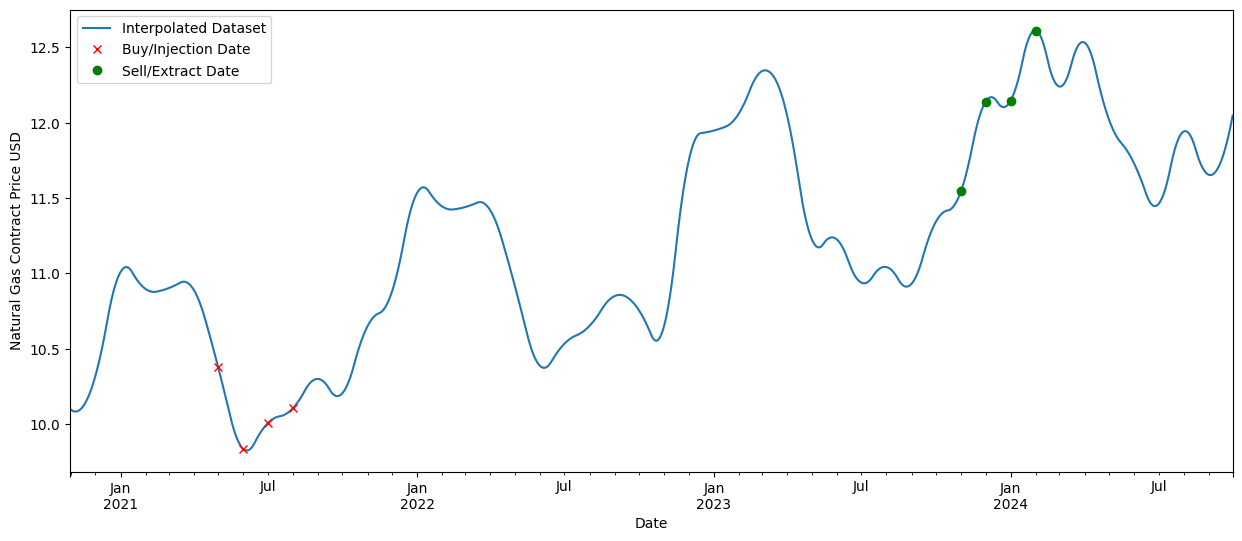

In [148]:
# input parameters
from datetime import date 

injection_dates = [date(2021, 5, 1), date(2021, 6, 1), date(2021, 7, 1), date(2021, 8, 1)]
withdrawal_dates = [date(2023, 11, 1), date(2023, 12, 1), date(2024, 1, 1), date(2024, 2, 1)]

injection_prices = [NG_price_lookup(interpolated_lookup_df, x) for x in injection_dates]
withdrawal_prices = [NG_price_lookup(interpolated_lookup_df, x) for x in withdrawal_dates]

rate = 100000  # rate of gas in cubic feet per day
inj_withd_cost_rate = 0.0005  # $/cf   #10e3 # USD / 1e6 MMBtu
storage_cost =  10000  # A fixed monthly fee to store the gas  #100e3 # USD/month 
max_storage_volume = 500000 # maximum storage capacity of the storage facility


# price of contract
price_of_contract = NG_pricing_model(injection_dates, withdrawal_dates, injection_prices, withdrawal_prices, rate, inj_withd_cost_rate, storage_cost, max_storage_volume)
print(f'Contract Price=${price_of_contract[0]}, Cash-in=${price_of_contract[1]}, Buy Cost=${price_of_contract[2]}, Gross Storage Cost=${price_of_contract[3]}')


# create a dictionary for date-price pair
injection_date_price_dict = dict( zip(injection_dates, injection_prices) )
withdrawal_date_price_dict = dict( zip(withdrawal_dates, withdrawal_prices) )
# convert to df
injection_df = pd.DataFrame(index=injection_date_price_dict.keys(), data=injection_date_price_dict.values(), columns=['Injection'])
withdrawal_df = pd.DataFrame(index=withdrawal_date_price_dict.keys(), data=withdrawal_date_price_dict.values(), columns=['Withdrawal'])
# parse date time indices
injection_df.index = pd.to_datetime(injection_df.index)
withdrawal_df.index = pd.to_datetime(withdrawal_df.index)


plt.figure(figsize=(15,6))
interpolated_lookup_df['predicted_mean'].plot()
injection_df['Injection'].plot(style='x', color='red')
withdrawal_df['Withdrawal'].plot(style='o', color='green')

plt.legend(labels=['Interpolated Dataset', 'Buy/Injection Date', 'Sell/Extract Date'])
plt.ylabel('Natural Gas Contract Price USD')
plt.xlabel('Date')

plt.show()

